## Question 1: Implement a Convolutional Neural Network


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [ ]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


In [ ]:
#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512]
num_epochs = 20
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg = 0.001
num_training = 49000
num_validation =1000
norm_layer = None

In [ ]:
#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
#################################################################################
# TODO: Q3.a Choose the right data augmentation transforms with the right       #
# hyper-parameters and put them in the data_aug_transforms variable             #
#################################################################################

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# data_aug_transforms = [transforms.Resize(32),
#                       transforms.ColorJitter(hue=.05, saturation=.05),
#                       transforms.RandomHorizontalFlip(),
#                       transforms.RandomRotation(20, resample=Image.BILINEAR)]
data_aug_transforms = []

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# norm_transform = transforms.Compose(data_aug_transforms + [transforms.ToTensor(),
#                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
norm_transform = transforms.Compose(data_aug_transforms + [transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# test_transform = transforms.Compose([transforms.ToTensor(),
#                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

cifar_dataset = torchvision.datasets.CIFAR10(root = 'datasets/',
                                           train = True,
                                           transform = norm_transform,
                                           download = True)

test_dataset = torchvision.datasets.CIFAR10(root = 'datasets/',
                                          train = False,
                                          transform = test_transform)

Files already downloaded and verified


In [ ]:
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

In [ ]:
#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

### a)
We implement the architecture shown in Fig.1, with five convolution blocks.
Each block consists of convolution, max pooling, and ReLU operations.

### b)
We implement a function *PrintModelSize*, which calculates and prints the bumber of parameters.

### c)
Visualize the filters of the first convolution layer implemented in the previous model.

In [ ]:
#-------------------------------------------------
# Convolutional neural network (Q1.a and Q2.a)
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer = None, drop = None):
        super(ConvNet, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the convolutional layer    #
        # described in the exercise.                                                    #
        # For Q1.a make use of conv2d and relu layers from the torch.nn module.         #
        # For Q2.a make use of BatchNorm2d layer from the torch.nn module.              #
        # For Q3.b Use Dropout layer from the torch.nn module.                          #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        for i in hidden_size:
            layers.append(nn.Conv2d(input_size, i, kernel_size = (3,3),
                                    padding = 1))
            if norm_layer == "BN":
                layers.append(nn.BatchNorm2d(i))
            layers.append(nn.MaxPool2d(kernel_size = (2,2), stride = 2))
            layers.append(nn.ReLU())
            if drop is not None:
              layers.append(nn.Dropout(drop))
            input_size = i
            
        layers.append(torch.nn.Flatten())
        layers.append(nn.Linear(input_size, num_classes))

        self.layers = nn.Sequential(*layers)
                                    
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = self.layers(x)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out



#-------------------------------------------------
# Calculate the model size (Q1.b)
# if disp is true, print the model parameters, otherwise, only return the number of parameters.
#-------------------------------------------------
def PrintModelSize(model, disp=True):
    #################################################################################
    # TODO: Implement the function to count the number of trainable parameters in   #
    # the input model. This useful to track the capacity of the model you are       #
    # training                                                                      #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    table = PrettyTable(["Modules", "Parameters"])
    model_sz = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        model_sz += params
    print(table)
    print(f"Total Trainable Params: {model_sz}")       
    

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model_sz



#-------------------------------------------------
# Calculate the model size (Q1.c)
# visualize the convolution filters of the first convolution layer of the input model
#-------------------------------------------------
def VisualizeFilter(model):
    #################################################################################
    # TODO: Implement the functiont to visualize the weights in the first conv layer#
    # in the model. Visualize them as a single image of stacked filters.            #
    # You can use matlplotlib.imshow to visualize an image in python                #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    ix = 1
    for _ in range(8):
        for _ in range(16):
            # specify subplot and turn of axis
            ax = plt.subplot(8, 16, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            img = model.layers[0].weight.data.cpu().numpy()[ix-1, :, :, :]
            plt.imshow((img * 255).astype(np.uint8))
            ix += 1
    # show the figure
    plt.show()

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

--------------------------------------------------------------------------
ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=Fal

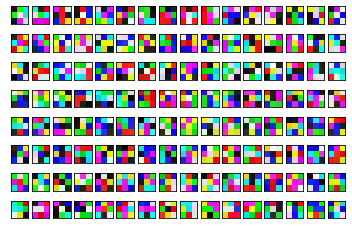

In [ ]:
#======================================================================================
# Q1.a: Implementing convolutional neural net in PyTorch
#======================================================================================
# In this question we will implement a convolutional neural networks using the PyTorch
# library.  Please complete the code for the ConvNet class evaluating the model
#--------------------------------------------------------------------------------------
model = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer).to(device)
# Q2.a - Initialize the model with correct batch norm layer

model.apply(weights_init)
print("--------------------------------------------------------------------------")
# Print the model
print(model)
print("--------------------------------------------------------------------------")
# Print model size
#======================================================================================
# Q1.b: Implementing the function to count the number of trainable parameters in the model
#======================================================================================
PrintModelSize(model)
print("--------------------------------------------------------------------------")
# #======================================================================================
# # Q1.a: Implementing the function to visualize the filters in the first conv layers.
# # Visualize the filters before training
# #======================================================================================
VisualizeFilter(model)

In [ ]:
## Function to train the model

def train_model(model, early_stop = False):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = reg)

    # Train the model
    lr = learning_rate
    total_step = len(train_loader)
    loss_train = []
    loss_val = []
    best_accuracy = None
    accuracy_val = []
    best_model = type(model)(input_size, hidden_size, num_classes, norm_layer = None) # get a new instance
    #best_model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer)
    for epoch in tqdm(range(num_epochs)):

        model.train()

        loss_iter = 0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_iter += loss.item()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                
        epoch_loss_train = loss_iter/(len(train_loader)*batch_size)
        loss_train.append(epoch_loss_train)

        
        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        
            
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            loss_iter = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                loss = criterion(outputs, labels)
                loss_iter += loss.item()
            
            epoch_loss_val = loss_iter/(len(val_loader)*batch_size)
            loss_val.append(epoch_loss_val)
            
            accuracy = 100 * correct / total
            accuracy_val.append(accuracy)
            print('Validation accuracy is: {} %'.format(accuracy))

        # early stopping
        if early_stop == True:
            early_stopping(epoch_loss_train, epoch_loss_val)
            if early_stopping.early_stop:
                print("We are at epoch:", epoch)
                break

    res = [loss_train, loss_val, accuracy_val]
    return(res)

In [ ]:
## Train the model without BN
loss_train, loss_val, accuracy_val = train_model(model)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.7580
Epoch [1/20], Step [200/245], Loss: 1.3329


  5%|▌         | 1/20 [00:30<09:46, 30.87s/it]

Validation accuracy is: 55.1 %
Epoch [2/20], Step [100/245], Loss: 1.0573
Epoch [2/20], Step [200/245], Loss: 1.0229


 10%|█         | 2/20 [00:57<08:27, 28.22s/it]

Validation accuracy is: 63.8 %
Epoch [3/20], Step [100/245], Loss: 0.8747
Epoch [3/20], Step [200/245], Loss: 0.7253


 15%|█▌        | 3/20 [01:24<07:49, 27.60s/it]

Validation accuracy is: 71.1 %
Epoch [4/20], Step [100/245], Loss: 0.7880
Epoch [4/20], Step [200/245], Loss: 0.6141


 20%|██        | 4/20 [01:50<07:12, 27.03s/it]

Validation accuracy is: 72.7 %
Epoch [5/20], Step [100/245], Loss: 0.6909
Epoch [5/20], Step [200/245], Loss: 0.7750


 25%|██▌       | 5/20 [02:16<06:41, 26.77s/it]

Validation accuracy is: 77.0 %
Epoch [6/20], Step [100/245], Loss: 0.5826
Epoch [6/20], Step [200/245], Loss: 0.6742


 30%|███       | 6/20 [02:42<06:12, 26.58s/it]

Validation accuracy is: 77.6 %
Epoch [7/20], Step [100/245], Loss: 0.5020
Epoch [7/20], Step [200/245], Loss: 0.4698


 35%|███▌      | 7/20 [03:08<05:43, 26.46s/it]

Validation accuracy is: 76.7 %
Epoch [8/20], Step [100/245], Loss: 0.4497
Epoch [8/20], Step [200/245], Loss: 0.4611


 40%|████      | 8/20 [03:35<05:17, 26.49s/it]

Validation accuracy is: 78.3 %
Epoch [9/20], Step [100/245], Loss: 0.4800
Epoch [9/20], Step [200/245], Loss: 0.3749


 45%|████▌     | 9/20 [04:01<04:50, 26.40s/it]

Validation accuracy is: 80.1 %
Epoch [10/20], Step [100/245], Loss: 0.2981
Epoch [10/20], Step [200/245], Loss: 0.2549


 50%|█████     | 10/20 [04:27<04:22, 26.29s/it]

Validation accuracy is: 81.0 %
Epoch [11/20], Step [100/245], Loss: 0.2021
Epoch [11/20], Step [200/245], Loss: 0.3957


 55%|█████▌    | 11/20 [04:53<03:56, 26.23s/it]

Validation accuracy is: 81.5 %
Epoch [12/20], Step [100/245], Loss: 0.2087
Epoch [12/20], Step [200/245], Loss: 0.2682


 60%|██████    | 12/20 [05:20<03:29, 26.21s/it]

Validation accuracy is: 80.3 %
Epoch [13/20], Step [100/245], Loss: 0.1811
Epoch [13/20], Step [200/245], Loss: 0.1710


 65%|██████▌   | 13/20 [05:46<03:03, 26.17s/it]

Validation accuracy is: 81.3 %
Epoch [14/20], Step [100/245], Loss: 0.1373
Epoch [14/20], Step [200/245], Loss: 0.1900


 70%|███████   | 14/20 [06:12<02:36, 26.16s/it]

Validation accuracy is: 78.5 %
Epoch [15/20], Step [100/245], Loss: 0.1010
Epoch [15/20], Step [200/245], Loss: 0.1439


 75%|███████▌  | 15/20 [06:38<02:10, 26.14s/it]

Validation accuracy is: 79.2 %
Epoch [16/20], Step [100/245], Loss: 0.1506
Epoch [16/20], Step [200/245], Loss: 0.1266


 80%|████████  | 16/20 [07:04<01:44, 26.24s/it]

Validation accuracy is: 79.6 %
Epoch [17/20], Step [100/245], Loss: 0.1084
Epoch [17/20], Step [200/245], Loss: 0.0863


 85%|████████▌ | 17/20 [07:30<01:18, 26.19s/it]

Validation accuracy is: 80.7 %
Epoch [18/20], Step [100/245], Loss: 0.0712
Epoch [18/20], Step [200/245], Loss: 0.1242


 90%|█████████ | 18/20 [07:56<00:52, 26.12s/it]

Validation accuracy is: 81.0 %
Epoch [19/20], Step [100/245], Loss: 0.0772
Epoch [19/20], Step [200/245], Loss: 0.0512


 95%|█████████▌| 19/20 [08:22<00:26, 26.06s/it]

Validation accuracy is: 80.3 %
Epoch [20/20], Step [100/245], Loss: 0.0678
Epoch [20/20], Step [200/245], Loss: 0.0601


100%|██████████| 20/20 [08:49<00:00, 26.46s/it]

Validation accuracy is: 80.7 %


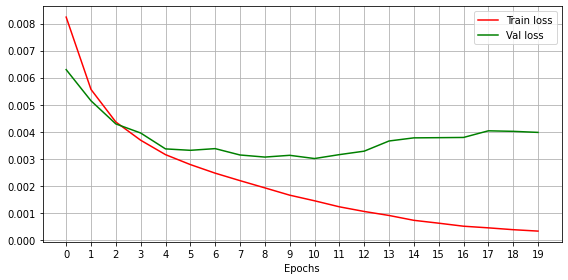

--------------------------------------------------------------------------


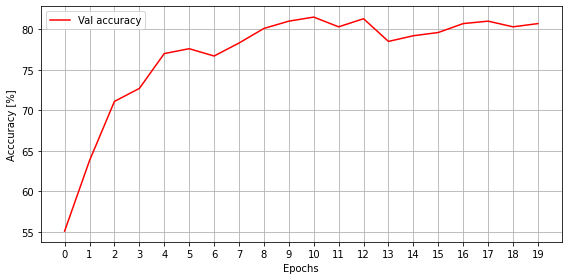

In [ ]:
## Plot validation and training losses
model.eval()

plt.rcParams["figure.figsize"] = (8,4)
plt.figure(2)
plt.plot(loss_train, 'r', label = 'Train loss')
plt.plot(loss_val, 'g', label = 'Val loss')
plt.xticks(range(0, num_epochs))
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
                                                            
print("--------------------------------------------------------------------------")

## Plot validation accuracy 
plt.rcParams["figure.figsize"] = (8,4)
plt.figure(3)
plt.plot(accuracy_val, "r", label = 'Val accuracy')
plt.xticks(range(0, num_epochs))
plt.ylabel('Acccuracy [%]')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## Performance
print("Best accuracy:", max(accuracy_val), "with epoch:", accuracy_val.index(max(accuracy_val))+1)
print("----------------------------------")
print("Min loss:", round(min(loss_val), 5), "with epoch:", loss_val.index(min(loss_val)))

Best accuracy: 81.5 with epoch: 11
----------------------------------
Min loss: 0.00301 with epoch: 10


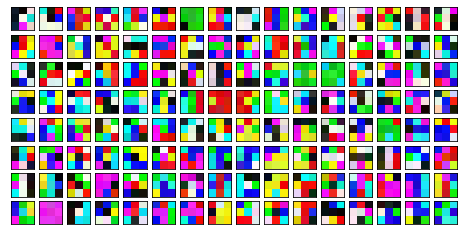

In [ ]:
## Visualize filter after the training of the model
VisualizeFilter(model)

As we can see, after the training step, some filters appear the same color, this could mean that the networks is starting to find common patterns.

In [ ]:
## Adding Batch Normalization
norm_layer = "BN"
model = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer).to(device)
model.apply(weights_init)

ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
## Training model with BN
loss_train, loss_val, accuracy_val = train_model(model)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.2969
Epoch [1/20], Step [200/245], Loss: 1.2172


  5%|▌         | 1/20 [00:29<09:22, 29.58s/it]

Validation accuracy is: 60.5 %
Epoch [2/20], Step [100/245], Loss: 0.9687
Epoch [2/20], Step [200/245], Loss: 0.8400


 10%|█         | 2/20 [01:01<09:15, 30.88s/it]

Validation accuracy is: 59.8 %
Epoch [3/20], Step [100/245], Loss: 0.9169
Epoch [3/20], Step [200/245], Loss: 0.7441


 15%|█▌        | 3/20 [01:31<08:35, 30.35s/it]

Validation accuracy is: 67.0 %
Epoch [4/20], Step [100/245], Loss: 0.6340
Epoch [4/20], Step [200/245], Loss: 0.7239


 20%|██        | 4/20 [02:00<08:02, 30.13s/it]

Validation accuracy is: 72.8 %
Epoch [5/20], Step [100/245], Loss: 0.6205
Epoch [5/20], Step [200/245], Loss: 0.6936


 25%|██▌       | 5/20 [02:30<07:26, 29.78s/it]

Validation accuracy is: 79.1 %
Epoch [6/20], Step [100/245], Loss: 0.5807
Epoch [6/20], Step [200/245], Loss: 0.6148


 30%|███       | 6/20 [02:59<06:53, 29.56s/it]

Validation accuracy is: 70.7 %
Epoch [7/20], Step [100/245], Loss: 0.4703
Epoch [7/20], Step [200/245], Loss: 0.5214


 35%|███▌      | 7/20 [03:27<06:20, 29.29s/it]

Validation accuracy is: 80.7 %
Epoch [8/20], Step [100/245], Loss: 0.3744
Epoch [8/20], Step [200/245], Loss: 0.3758


 40%|████      | 8/20 [03:56<05:49, 29.12s/it]

Validation accuracy is: 80.7 %
Epoch [9/20], Step [100/245], Loss: 0.4570
Epoch [9/20], Step [200/245], Loss: 0.3797


 45%|████▌     | 9/20 [04:25<05:18, 28.98s/it]

Validation accuracy is: 81.2 %
Epoch [10/20], Step [100/245], Loss: 0.2849
Epoch [10/20], Step [200/245], Loss: 0.3126


 50%|█████     | 10/20 [04:54<04:49, 28.94s/it]

Validation accuracy is: 78.2 %
Epoch [11/20], Step [100/245], Loss: 0.1715
Epoch [11/20], Step [200/245], Loss: 0.3151


 55%|█████▌    | 11/20 [05:22<04:19, 28.84s/it]

Validation accuracy is: 79.7 %
Epoch [12/20], Step [100/245], Loss: 0.1879
Epoch [12/20], Step [200/245], Loss: 0.2282


 60%|██████    | 12/20 [05:51<03:49, 28.72s/it]

Validation accuracy is: 78.9 %
Epoch [13/20], Step [100/245], Loss: 0.1906
Epoch [13/20], Step [200/245], Loss: 0.1784


 65%|██████▌   | 13/20 [06:19<03:20, 28.64s/it]

Validation accuracy is: 82.4 %
Epoch [14/20], Step [100/245], Loss: 0.1193
Epoch [14/20], Step [200/245], Loss: 0.1376


 70%|███████   | 14/20 [06:48<02:51, 28.57s/it]

Validation accuracy is: 78.6 %
Epoch [15/20], Step [100/245], Loss: 0.0964
Epoch [15/20], Step [200/245], Loss: 0.0648


 75%|███████▌  | 15/20 [07:16<02:22, 28.49s/it]

Validation accuracy is: 82.2 %
Epoch [16/20], Step [100/245], Loss: 0.0969
Epoch [16/20], Step [200/245], Loss: 0.1191


 80%|████████  | 16/20 [07:44<01:53, 28.42s/it]

Validation accuracy is: 82.3 %
Epoch [17/20], Step [100/245], Loss: 0.0520
Epoch [17/20], Step [200/245], Loss: 0.0565


 85%|████████▌ | 17/20 [08:12<01:25, 28.38s/it]

Validation accuracy is: 81.1 %
Epoch [18/20], Step [100/245], Loss: 0.0706
Epoch [18/20], Step [200/245], Loss: 0.0986


 90%|█████████ | 18/20 [08:41<00:56, 28.45s/it]

Validation accuracy is: 80.5 %
Epoch [19/20], Step [100/245], Loss: 0.0571
Epoch [19/20], Step [200/245], Loss: 0.1067


 95%|█████████▌| 19/20 [09:09<00:28, 28.38s/it]

Validation accuracy is: 81.6 %
Epoch [20/20], Step [100/245], Loss: 0.0229
Epoch [20/20], Step [200/245], Loss: 0.0892


100%|██████████| 20/20 [09:38<00:00, 28.90s/it]

Validation accuracy is: 81.9 %


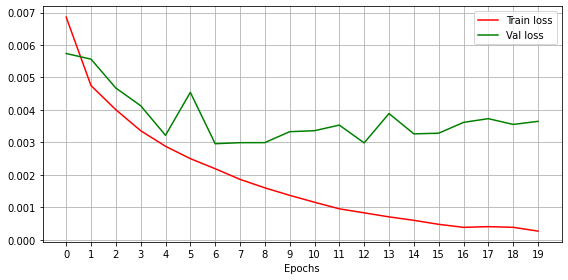

--------------------------------------------------------------------------


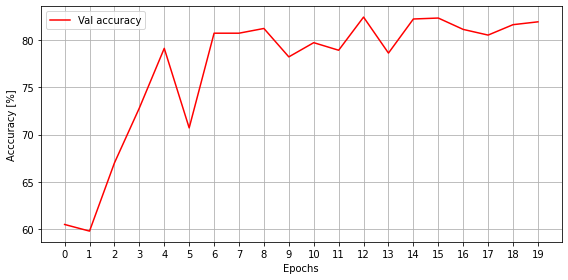

In [ ]:
## Plot validation and training losses
model.eval()

plt.rcParams["figure.figsize"] = (8,4)
plt.figure(2)
plt.plot(loss_train, 'r', label = 'Train loss')
plt.plot(loss_val, 'g', label = 'Val loss')
plt.xticks(range(0, num_epochs))
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
                                                            
print("--------------------------------------------------------------------------")

## Plot validation accuracy
plt.rcParams["figure.figsize"] = (8,4)
plt.figure(3)
plt.plot(accuracy_val, "r", label = 'Val accuracy')
plt.xticks(range(0, num_epochs))
plt.ylabel('Acccuracy [%]')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## Performance
print("Best accuracy:", max(accuracy_val), "with epoch:", accuracy_val.index(max(accuracy_val)))
print("----------------------------------")
print("Min loss:", round(min(loss_val), 5), "with epoch:", loss_val.index(min(loss_val)))

Best accuracy: 82.4 with epoch: 12
----------------------------------
Min loss: 0.00296 with epoch: 6


Adding the batch normalization, we obtain a slightly better performance.

## Question 2: Improve training of Convolutional Networks

### a)
In order to increase the speed of convergence, we add batch normalization in the previous model.

### b)
At this step, we use the early stopping technique to alleviate overfitting. Instead of reporting the performance of final model, with this method we save the best model on the validation set during training.

We increase the number of epochs to 50.

In [ ]:
## Implement Class
class EarlyStopping():
    def __init__(self, tolerance = 5, min_delta = 0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [ ]:
## Early Stopping
early_stopping = EarlyStopping(tolerance = 5, min_delta = 10)

In [ ]:
## Train the model without BN and without early stop
norm_layer = None
num_epochs = 50

## Init model
model = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer).to(device)
model.apply(weights_init)

## Train Model
loss_train, loss_val, accuracy_val =  train_model(model, early_stop = False)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Step [100/245], Loss: 1.6044
Epoch [1/50], Step [200/245], Loss: 1.3762


  2%|▏         | 1/50 [00:26<21:38, 26.50s/it]

Validation accuracy is: 54.3 %
Epoch [2/50], Step [100/245], Loss: 1.0812
Epoch [2/50], Step [200/245], Loss: 0.9659


  4%|▍         | 2/50 [00:52<21:05, 26.36s/it]

Validation accuracy is: 65.5 %
Epoch [3/50], Step [100/245], Loss: 0.7422
Epoch [3/50], Step [200/245], Loss: 0.9114


  6%|▌         | 3/50 [01:18<20:26, 26.09s/it]

Validation accuracy is: 71.1 %
Epoch [4/50], Step [100/245], Loss: 0.7972
Epoch [4/50], Step [200/245], Loss: 0.7882


  8%|▊         | 4/50 [01:43<19:47, 25.82s/it]

Validation accuracy is: 73.2 %
Epoch [5/50], Step [100/245], Loss: 0.5916
Epoch [5/50], Step [200/245], Loss: 0.5787


 10%|█         | 5/50 [02:09<19:23, 25.85s/it]

Validation accuracy is: 76.0 %
Epoch [6/50], Step [100/245], Loss: 0.6001
Epoch [6/50], Step [200/245], Loss: 0.5492


 12%|█▏        | 6/50 [02:35<18:54, 25.78s/it]

Validation accuracy is: 76.3 %
Epoch [7/50], Step [100/245], Loss: 0.4335
Epoch [7/50], Step [200/245], Loss: 0.5013


 14%|█▍        | 7/50 [03:01<18:31, 25.85s/it]

Validation accuracy is: 79.9 %
Epoch [8/50], Step [100/245], Loss: 0.5099
Epoch [8/50], Step [200/245], Loss: 0.4479


 16%|█▌        | 8/50 [03:26<17:59, 25.70s/it]

Validation accuracy is: 79.8 %
Epoch [9/50], Step [100/245], Loss: 0.4986
Epoch [9/50], Step [200/245], Loss: 0.3488


 18%|█▊        | 9/50 [03:52<17:34, 25.72s/it]

Validation accuracy is: 78.6 %
Epoch [10/50], Step [100/245], Loss: 0.3620
Epoch [10/50], Step [200/245], Loss: 0.2552


 20%|██        | 10/50 [04:18<17:04, 25.62s/it]

Validation accuracy is: 80.4 %
Epoch [11/50], Step [100/245], Loss: 0.2525
Epoch [11/50], Step [200/245], Loss: 0.4189


 22%|██▏       | 11/50 [04:43<16:37, 25.57s/it]

Validation accuracy is: 81.3 %
Epoch [12/50], Step [100/245], Loss: 0.2387
Epoch [12/50], Step [200/245], Loss: 0.3991


 24%|██▍       | 12/50 [05:08<16:10, 25.53s/it]

Validation accuracy is: 81.5 %
Epoch [13/50], Step [100/245], Loss: 0.1824
Epoch [13/50], Step [200/245], Loss: 0.2712


 26%|██▌       | 13/50 [05:34<15:42, 25.48s/it]

Validation accuracy is: 80.8 %
Epoch [14/50], Step [100/245], Loss: 0.2298
Epoch [14/50], Step [200/245], Loss: 0.2055


 28%|██▊       | 14/50 [05:59<15:16, 25.45s/it]

Validation accuracy is: 79.6 %
Epoch [15/50], Step [100/245], Loss: 0.1929
Epoch [15/50], Step [200/245], Loss: 0.2718


 30%|███       | 15/50 [06:24<14:49, 25.41s/it]

Validation accuracy is: 79.3 %
Epoch [16/50], Step [100/245], Loss: 0.1845
Epoch [16/50], Step [200/245], Loss: 0.1847


 32%|███▏      | 16/50 [06:50<14:24, 25.42s/it]

Validation accuracy is: 80.8 %
Epoch [17/50], Step [100/245], Loss: 0.1418
Epoch [17/50], Step [200/245], Loss: 0.1347


 34%|███▍      | 17/50 [07:16<14:01, 25.51s/it]

Validation accuracy is: 82.3 %
Epoch [18/50], Step [100/245], Loss: 0.0769
Epoch [18/50], Step [200/245], Loss: 0.1549


 36%|███▌      | 18/50 [07:41<13:35, 25.49s/it]

Validation accuracy is: 80.6 %
Epoch [19/50], Step [100/245], Loss: 0.0722
Epoch [19/50], Step [200/245], Loss: 0.1280


 38%|███▊      | 19/50 [08:07<13:09, 25.48s/it]

Validation accuracy is: 80.6 %
Epoch [20/50], Step [100/245], Loss: 0.0981
Epoch [20/50], Step [200/245], Loss: 0.0798


 40%|████      | 20/50 [08:32<12:44, 25.49s/it]

Validation accuracy is: 80.3 %
Epoch [21/50], Step [100/245], Loss: 0.0800
Epoch [21/50], Step [200/245], Loss: 0.0911


 42%|████▏     | 21/50 [08:58<12:19, 25.48s/it]

Validation accuracy is: 81.4 %
Epoch [22/50], Step [100/245], Loss: 0.0510
Epoch [22/50], Step [200/245], Loss: 0.0830


 44%|████▍     | 22/50 [09:23<11:51, 25.43s/it]

Validation accuracy is: 81.3 %
Epoch [23/50], Step [100/245], Loss: 0.0505
Epoch [23/50], Step [200/245], Loss: 0.0597


 46%|████▌     | 23/50 [09:48<11:26, 25.42s/it]

Validation accuracy is: 82.0 %
Epoch [24/50], Step [100/245], Loss: 0.0385
Epoch [24/50], Step [200/245], Loss: 0.0377


 48%|████▊     | 24/50 [10:13<10:59, 25.37s/it]

Validation accuracy is: 81.6 %
Epoch [25/50], Step [100/245], Loss: 0.0380
Epoch [25/50], Step [200/245], Loss: 0.0630


 50%|█████     | 25/50 [10:39<10:37, 25.51s/it]

Validation accuracy is: 81.5 %
Epoch [26/50], Step [100/245], Loss: 0.0600
Epoch [26/50], Step [200/245], Loss: 0.0645


 52%|█████▏    | 26/50 [11:05<10:11, 25.47s/it]

Validation accuracy is: 80.3 %
Epoch [27/50], Step [100/245], Loss: 0.0421
Epoch [27/50], Step [200/245], Loss: 0.0852


 54%|█████▍    | 27/50 [11:30<09:45, 25.44s/it]

Validation accuracy is: 81.0 %
Epoch [28/50], Step [100/245], Loss: 0.0252
Epoch [28/50], Step [200/245], Loss: 0.0415


 56%|█████▌    | 28/50 [11:55<09:19, 25.43s/it]

Validation accuracy is: 80.6 %
Epoch [29/50], Step [100/245], Loss: 0.0223
Epoch [29/50], Step [200/245], Loss: 0.0352


 58%|█████▊    | 29/50 [12:21<08:54, 25.43s/it]

Validation accuracy is: 80.9 %
Epoch [30/50], Step [100/245], Loss: 0.0223
Epoch [30/50], Step [200/245], Loss: 0.0416


 60%|██████    | 30/50 [12:46<08:28, 25.42s/it]

Validation accuracy is: 81.4 %
Epoch [31/50], Step [100/245], Loss: 0.0268
Epoch [31/50], Step [200/245], Loss: 0.0358


 62%|██████▏   | 31/50 [13:12<08:02, 25.41s/it]

Validation accuracy is: 80.9 %
Epoch [32/50], Step [100/245], Loss: 0.0310
Epoch [32/50], Step [200/245], Loss: 0.0161


 64%|██████▍   | 32/50 [13:37<07:36, 25.39s/it]

Validation accuracy is: 80.7 %
Epoch [33/50], Step [100/245], Loss: 0.0229
Epoch [33/50], Step [200/245], Loss: 0.0401


 66%|██████▌   | 33/50 [14:03<07:13, 25.50s/it]

Validation accuracy is: 81.5 %
Epoch [34/50], Step [100/245], Loss: 0.0137
Epoch [34/50], Step [200/245], Loss: 0.0478


 68%|██████▊   | 34/50 [14:28<06:47, 25.47s/it]

Validation accuracy is: 82.1 %
Epoch [35/50], Step [100/245], Loss: 0.0194
Epoch [35/50], Step [200/245], Loss: 0.0283


 70%|███████   | 35/50 [14:54<06:21, 25.45s/it]

Validation accuracy is: 83.1 %
Epoch [36/50], Step [100/245], Loss: 0.0131
Epoch [36/50], Step [200/245], Loss: 0.0171


 72%|███████▏  | 36/50 [15:19<05:56, 25.44s/it]

Validation accuracy is: 80.7 %
Epoch [37/50], Step [100/245], Loss: 0.0129
Epoch [37/50], Step [200/245], Loss: 0.0338


 74%|███████▍  | 37/50 [15:45<05:31, 25.46s/it]

Validation accuracy is: 81.7 %
Epoch [38/50], Step [100/245], Loss: 0.0208
Epoch [38/50], Step [200/245], Loss: 0.0269


 76%|███████▌  | 38/50 [16:10<05:05, 25.47s/it]

Validation accuracy is: 81.1 %
Epoch [39/50], Step [100/245], Loss: 0.0090
Epoch [39/50], Step [200/245], Loss: 0.0138


 78%|███████▊  | 39/50 [16:35<04:40, 25.46s/it]

Validation accuracy is: 82.2 %
Epoch [40/50], Step [100/245], Loss: 0.0129
Epoch [40/50], Step [200/245], Loss: 0.0139


 80%|████████  | 40/50 [17:01<04:13, 25.39s/it]

Validation accuracy is: 81.7 %
Epoch [41/50], Step [100/245], Loss: 0.0195
Epoch [41/50], Step [200/245], Loss: 0.0232


 82%|████████▏ | 41/50 [17:26<03:49, 25.47s/it]

Validation accuracy is: 80.7 %
Epoch [42/50], Step [100/245], Loss: 0.0147
Epoch [42/50], Step [200/245], Loss: 0.0158


 84%|████████▍ | 42/50 [17:52<03:23, 25.44s/it]

Validation accuracy is: 81.6 %
Epoch [43/50], Step [100/245], Loss: 0.0084
Epoch [43/50], Step [200/245], Loss: 0.0150


 86%|████████▌ | 43/50 [18:17<02:57, 25.42s/it]

Validation accuracy is: 80.8 %
Epoch [44/50], Step [100/245], Loss: 0.0132
Epoch [44/50], Step [200/245], Loss: 0.0152


 88%|████████▊ | 44/50 [18:42<02:32, 25.42s/it]

Validation accuracy is: 82.1 %
Epoch [45/50], Step [100/245], Loss: 0.0090
Epoch [45/50], Step [200/245], Loss: 0.0177


 90%|█████████ | 45/50 [19:08<02:07, 25.40s/it]

Validation accuracy is: 82.0 %
Epoch [46/50], Step [100/245], Loss: 0.0109
Epoch [46/50], Step [200/245], Loss: 0.0167


 92%|█████████▏| 46/50 [19:33<01:41, 25.42s/it]

Validation accuracy is: 80.8 %
Epoch [47/50], Step [100/245], Loss: 0.0126
Epoch [47/50], Step [200/245], Loss: 0.0119


 94%|█████████▍| 47/50 [19:59<01:16, 25.43s/it]

Validation accuracy is: 82.1 %
Epoch [48/50], Step [100/245], Loss: 0.0164
Epoch [48/50], Step [200/245], Loss: 0.0178


 96%|█████████▌| 48/50 [20:24<00:50, 25.46s/it]

Validation accuracy is: 82.0 %
Epoch [49/50], Step [100/245], Loss: 0.0107
Epoch [49/50], Step [200/245], Loss: 0.0168


 98%|█████████▊| 49/50 [20:50<00:25, 25.52s/it]

Validation accuracy is: 81.4 %
Epoch [50/50], Step [100/245], Loss: 0.0113
Epoch [50/50], Step [200/245], Loss: 0.0176


100%|██████████| 50/50 [21:16<00:00, 25.52s/it]

Validation accuracy is: 79.9 %


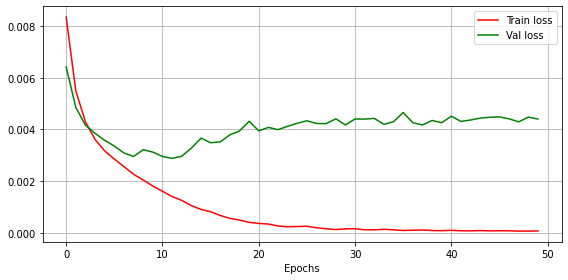

--------------------------------------------------------------------------


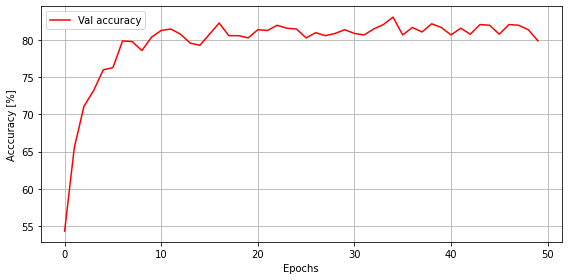

In [ ]:
## Plot validation and training losses
model.eval()

plt.rcParams["figure.figsize"] = (8,4)
plt.figure(2)
plt.plot(loss_train, 'r', label = 'Train loss')
plt.plot(loss_val, 'g', label = 'Val loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
                                                            
print("--------------------------------------------------------------------------")

## Plot validation accuracy
plt.rcParams["figure.figsize"] = (8,4)
plt.figure(3)
plt.plot(accuracy_val, "r", label = 'Val accuracy')
plt.ylabel('Acccuracy [%]')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## Train the model without BN and with early stop
norm_layer = None
num_epochs = 50

## Init model
model = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer).to(device)
model.apply(weights_init)

## Train Model
loss_train, loss_val, accuracy_val =  train_model(model, early_stop = True)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Step [100/245], Loss: 1.7331
Epoch [1/50], Step [200/245], Loss: 1.3752


  2%|▏         | 1/50 [00:25<20:47, 25.47s/it]

Validation accuracy is: 50.7 %
Epoch [2/50], Step [100/245], Loss: 1.1694
Epoch [2/50], Step [200/245], Loss: 1.0872


  4%|▍         | 2/50 [00:50<20:22, 25.46s/it]

Validation accuracy is: 64.0 %
Epoch [3/50], Step [100/245], Loss: 0.8365
Epoch [3/50], Step [200/245], Loss: 0.7932


  6%|▌         | 3/50 [01:16<19:55, 25.44s/it]

Validation accuracy is: 69.0 %
Epoch [4/50], Step [100/245], Loss: 0.7419
Epoch [4/50], Step [200/245], Loss: 0.7590


  8%|▊         | 4/50 [01:41<19:30, 25.44s/it]

Validation accuracy is: 72.1 %
Epoch [5/50], Step [100/245], Loss: 0.7385
Epoch [5/50], Step [200/245], Loss: 0.6779


 10%|█         | 5/50 [02:07<19:03, 25.42s/it]

Validation accuracy is: 74.4 %
Epoch [6/50], Step [100/245], Loss: 0.7460
Epoch [6/50], Step [200/245], Loss: 0.7357


 12%|█▏        | 6/50 [02:32<18:38, 25.41s/it]

Validation accuracy is: 77.2 %
Epoch [7/50], Step [100/245], Loss: 0.6185
Epoch [7/50], Step [200/245], Loss: 0.7428


 14%|█▍        | 7/50 [02:58<18:13, 25.43s/it]

Validation accuracy is: 77.2 %
Epoch [8/50], Step [100/245], Loss: 0.5089
Epoch [8/50], Step [200/245], Loss: 0.6370


 16%|█▌        | 8/50 [03:23<17:53, 25.57s/it]

Validation accuracy is: 78.9 %
Epoch [9/50], Step [100/245], Loss: 0.4272
Epoch [9/50], Step [200/245], Loss: 0.4614


 18%|█▊        | 9/50 [03:49<17:25, 25.51s/it]

Validation accuracy is: 79.6 %
Epoch [10/50], Step [100/245], Loss: 0.4632
Epoch [10/50], Step [200/245], Loss: 0.5063


 20%|██        | 10/50 [04:14<16:57, 25.45s/it]

Validation accuracy is: 79.1 %
Epoch [11/50], Step [100/245], Loss: 0.2981
Epoch [11/50], Step [200/245], Loss: 0.4678


 22%|██▏       | 11/50 [04:39<16:31, 25.43s/it]

Validation accuracy is: 78.2 %
Epoch [12/50], Step [100/245], Loss: 0.3113
Epoch [12/50], Step [200/245], Loss: 0.4948


 24%|██▍       | 12/50 [05:05<16:05, 25.41s/it]

Validation accuracy is: 78.2 %
Epoch [13/50], Step [100/245], Loss: 0.3317
Epoch [13/50], Step [200/245], Loss: 0.3357


 26%|██▌       | 13/50 [05:30<15:39, 25.40s/it]

Validation accuracy is: 77.5 %
Epoch [14/50], Step [100/245], Loss: 0.3457
Epoch [14/50], Step [200/245], Loss: 0.3232


 28%|██▊       | 14/50 [05:56<15:13, 25.39s/it]

Validation accuracy is: 79.9 %
Epoch [15/50], Step [100/245], Loss: 0.3427
Epoch [15/50], Step [200/245], Loss: 0.3734


 30%|███       | 15/50 [06:21<14:47, 25.35s/it]

Validation accuracy is: 79.3 %
Epoch [16/50], Step [100/245], Loss: 0.1601
Epoch [16/50], Step [200/245], Loss: 0.2860


 32%|███▏      | 16/50 [06:46<14:24, 25.43s/it]

Validation accuracy is: 78.1 %
Epoch [17/50], Step [100/245], Loss: 0.2261
Epoch [17/50], Step [200/245], Loss: 0.3278


 34%|███▍      | 17/50 [07:12<13:58, 25.41s/it]

Validation accuracy is: 80.4 %
Epoch [18/50], Step [100/245], Loss: 0.1773
Epoch [18/50], Step [200/245], Loss: 0.2573


 36%|███▌      | 18/50 [07:37<13:31, 25.37s/it]

Validation accuracy is: 77.9 %
Epoch [19/50], Step [100/245], Loss: 0.1547
Epoch [19/50], Step [200/245], Loss: 0.2143


 38%|███▊      | 19/50 [08:02<13:06, 25.36s/it]

Validation accuracy is: 80.4 %
Epoch [20/50], Step [100/245], Loss: 0.1256
Epoch [20/50], Step [200/245], Loss: 0.2063


 40%|████      | 20/50 [08:28<12:40, 25.35s/it]

Validation accuracy is: 80.6 %
Epoch [21/50], Step [100/245], Loss: 0.1767
Epoch [21/50], Step [200/245], Loss: 0.1797


 42%|████▏     | 21/50 [08:53<12:14, 25.32s/it]

Validation accuracy is: 80.1 %
Epoch [22/50], Step [100/245], Loss: 0.1901
Epoch [22/50], Step [200/245], Loss: 0.1038


 44%|████▍     | 22/50 [09:18<11:48, 25.32s/it]

Validation accuracy is: 79.5 %
Epoch [23/50], Step [100/245], Loss: 0.0799
Epoch [23/50], Step [200/245], Loss: 0.0944


 46%|████▌     | 23/50 [09:44<11:24, 25.35s/it]

Validation accuracy is: 81.0 %
Epoch [24/50], Step [100/245], Loss: 0.1615
Epoch [24/50], Step [200/245], Loss: 0.0804


 48%|████▊     | 24/50 [10:09<11:01, 25.46s/it]

Validation accuracy is: 80.2 %
Epoch [25/50], Step [100/245], Loss: 0.0525
Epoch [25/50], Step [200/245], Loss: 0.0858


 50%|█████     | 25/50 [10:35<10:35, 25.41s/it]

Validation accuracy is: 80.2 %
Epoch [26/50], Step [100/245], Loss: 0.0544
Epoch [26/50], Step [200/245], Loss: 0.0623


 52%|█████▏    | 26/50 [11:00<10:09, 25.38s/it]

Validation accuracy is: 81.0 %
Epoch [27/50], Step [100/245], Loss: 0.0666
Epoch [27/50], Step [200/245], Loss: 0.0861


 54%|█████▍    | 27/50 [11:25<09:43, 25.38s/it]

Validation accuracy is: 79.8 %
Epoch [28/50], Step [100/245], Loss: 0.0754
Epoch [28/50], Step [200/245], Loss: 0.0895


 56%|█████▌    | 28/50 [11:51<09:18, 25.38s/it]

Validation accuracy is: 81.0 %
Epoch [29/50], Step [100/245], Loss: 0.0363
Epoch [29/50], Step [200/245], Loss: 0.0509


 58%|█████▊    | 29/50 [12:16<08:52, 25.35s/it]

Validation accuracy is: 80.5 %
Epoch [30/50], Step [100/245], Loss: 0.0315
Epoch [30/50], Step [200/245], Loss: 0.0734


 60%|██████    | 30/50 [12:41<08:27, 25.36s/it]

Validation accuracy is: 80.6 %
Epoch [31/50], Step [100/245], Loss: 0.0731
Epoch [31/50], Step [200/245], Loss: 0.0607


 62%|██████▏   | 31/50 [13:07<08:01, 25.33s/it]

Validation accuracy is: 80.5 %
Epoch [32/50], Step [100/245], Loss: 0.0286
Epoch [32/50], Step [200/245], Loss: 0.0555


 64%|██████▍   | 32/50 [13:32<07:37, 25.44s/it]

Validation accuracy is: 80.5 %
Epoch [33/50], Step [100/245], Loss: 0.0419
Epoch [33/50], Step [200/245], Loss: 0.0362


 66%|██████▌   | 33/50 [13:58<07:11, 25.40s/it]

Validation accuracy is: 81.0 %
Epoch [34/50], Step [100/245], Loss: 0.0232
Epoch [34/50], Step [200/245], Loss: 0.0435


 68%|██████▊   | 34/50 [14:23<06:45, 25.37s/it]

Validation accuracy is: 80.8 %
Epoch [35/50], Step [100/245], Loss: 0.0304
Epoch [35/50], Step [200/245], Loss: 0.0416


 70%|███████   | 35/50 [14:48<06:20, 25.39s/it]

Validation accuracy is: 79.8 %
Epoch [36/50], Step [100/245], Loss: 0.0176
Epoch [36/50], Step [200/245], Loss: 0.0342


 72%|███████▏  | 36/50 [15:14<05:55, 25.38s/it]

Validation accuracy is: 80.2 %
Epoch [37/50], Step [100/245], Loss: 0.0232
Epoch [37/50], Step [200/245], Loss: 0.0201


 74%|███████▍  | 37/50 [15:39<05:29, 25.35s/it]

Validation accuracy is: 80.8 %
Epoch [38/50], Step [100/245], Loss: 0.0198
Epoch [38/50], Step [200/245], Loss: 0.0526


 76%|███████▌  | 38/50 [16:04<05:04, 25.35s/it]

Validation accuracy is: 80.9 %
Epoch [39/50], Step [100/245], Loss: 0.0176
Epoch [39/50], Step [200/245], Loss: 0.0189


 78%|███████▊  | 39/50 [16:30<04:38, 25.33s/it]

Validation accuracy is: 81.1 %
Epoch [40/50], Step [100/245], Loss: 0.0146
Epoch [40/50], Step [200/245], Loss: 0.0259


 80%|████████  | 40/50 [16:55<04:14, 25.41s/it]

Validation accuracy is: 80.1 %
Epoch [41/50], Step [100/245], Loss: 0.0139
Epoch [41/50], Step [200/245], Loss: 0.0312


 82%|████████▏ | 41/50 [17:21<03:48, 25.40s/it]

Validation accuracy is: 79.9 %
Epoch [42/50], Step [100/245], Loss: 0.0188
Epoch [42/50], Step [200/245], Loss: 0.0214


 84%|████████▍ | 42/50 [17:46<03:22, 25.37s/it]

Validation accuracy is: 80.7 %
Epoch [43/50], Step [100/245], Loss: 0.0221
Epoch [43/50], Step [200/245], Loss: 0.0248


 86%|████████▌ | 43/50 [18:11<02:57, 25.35s/it]

Validation accuracy is: 80.1 %
Epoch [44/50], Step [100/245], Loss: 0.0204
Epoch [44/50], Step [200/245], Loss: 0.0232


 88%|████████▊ | 44/50 [18:37<02:31, 25.32s/it]

Validation accuracy is: 78.7 %
Epoch [45/50], Step [100/245], Loss: 0.0117
Epoch [45/50], Step [200/245], Loss: 0.0249


 90%|█████████ | 45/50 [19:02<02:06, 25.34s/it]

Validation accuracy is: 80.7 %
Epoch [46/50], Step [100/245], Loss: 0.0167
Epoch [46/50], Step [200/245], Loss: 0.0183


 92%|█████████▏| 46/50 [19:27<01:41, 25.35s/it]

Validation accuracy is: 80.4 %
Epoch [47/50], Step [100/245], Loss: 0.0163
Epoch [47/50], Step [200/245], Loss: 0.0209


 94%|█████████▍| 47/50 [19:53<01:16, 25.43s/it]

Validation accuracy is: 79.6 %
Epoch [48/50], Step [100/245], Loss: 0.0192
Epoch [48/50], Step [200/245], Loss: 0.0210


 96%|█████████▌| 48/50 [20:18<00:50, 25.41s/it]

Validation accuracy is: 79.9 %
Epoch [49/50], Step [100/245], Loss: 0.0139
Epoch [49/50], Step [200/245], Loss: 0.0216


 98%|█████████▊| 49/50 [20:44<00:25, 25.37s/it]

Validation accuracy is: 80.4 %
Epoch [50/50], Step [100/245], Loss: 0.0165
Epoch [50/50], Step [200/245], Loss: 0.0182


100%|██████████| 50/50 [21:09<00:00, 25.40s/it]

Validation accuracy is: 80.6 %


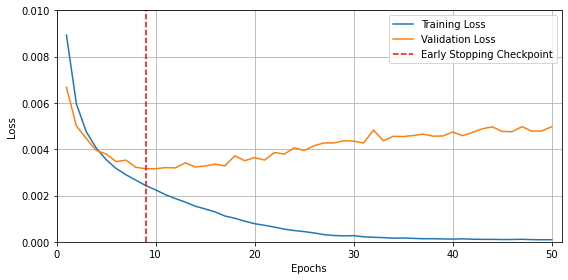

--------------------------------------------------------------------------


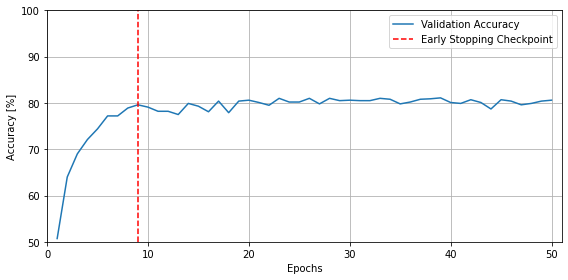

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train)+1),loss_train, label = 'Training Loss')
plt.plot(range(1,len(loss_val)+1),loss_val,label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val.index(min(loss_val))+1 
plt.axvline(minposs, linestyle='--', color='r',label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.01) # consistent scale
plt.xlim(0, len(loss_train)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## Plot validation accuracy

## Visualize accuracy plot
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(accuracy_val)+1),accuracy_val,label = 'Validation Accuracy')
# find position of lowest validation loss
minposs = loss_val.index(min(loss_val))+1 
plt.axvline(minposs, linestyle='--', color='r',label = 'Early Stopping Checkpoint')
plt.xlabel('Epochs')
plt.ylabel('Accuracy [%]')
plt.ylim(50, 100) # consistent scale
plt.xlim(0, len(loss_train)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
## Train the model witn BN and without early stop
norm_layer = "BN"
num_epochs = 50

## Init model
model = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer).to(device)
model.apply(weights_init)

## Train Model
loss_train, loss_val, accuracy_val =  train_model(model, early_stop = False)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Step [100/245], Loss: 1.3185
Epoch [1/50], Step [200/245], Loss: 1.0350


  2%|▏         | 1/50 [00:29<24:22, 29.85s/it]

Validation accuracy is: 43.5 %
Epoch [2/50], Step [100/245], Loss: 0.9966
Epoch [2/50], Step [200/245], Loss: 0.7845


  4%|▍         | 2/50 [01:00<24:09, 30.19s/it]

Validation accuracy is: 57.2 %
Epoch [3/50], Step [100/245], Loss: 0.7656
Epoch [3/50], Step [200/245], Loss: 0.8438


  6%|▌         | 3/50 [01:29<23:28, 29.97s/it]

Validation accuracy is: 72.7 %
Epoch [4/50], Step [100/245], Loss: 0.6708
Epoch [4/50], Step [200/245], Loss: 0.6264


  8%|▊         | 4/50 [01:59<22:48, 29.74s/it]

Validation accuracy is: 73.9 %
Epoch [5/50], Step [100/245], Loss: 0.5429
Epoch [5/50], Step [200/245], Loss: 0.5755


 10%|█         | 5/50 [02:28<22:12, 29.62s/it]

Validation accuracy is: 78.0 %
Epoch [6/50], Step [100/245], Loss: 0.3998
Epoch [6/50], Step [200/245], Loss: 0.5449


 12%|█▏        | 6/50 [02:58<21:38, 29.51s/it]

Validation accuracy is: 78.0 %
Epoch [7/50], Step [100/245], Loss: 0.3747
Epoch [7/50], Step [200/245], Loss: 0.5326


 14%|█▍        | 7/50 [03:27<21:02, 29.35s/it]

Validation accuracy is: 76.0 %
Epoch [8/50], Step [100/245], Loss: 0.4123
Epoch [8/50], Step [200/245], Loss: 0.4944


 16%|█▌        | 8/50 [03:55<20:25, 29.19s/it]

Validation accuracy is: 79.2 %
Epoch [9/50], Step [100/245], Loss: 0.2371
Epoch [9/50], Step [200/245], Loss: 0.3733


 18%|█▊        | 9/50 [04:24<19:53, 29.11s/it]

Validation accuracy is: 75.0 %
Epoch [10/50], Step [100/245], Loss: 0.3038
Epoch [10/50], Step [200/245], Loss: 0.2227


 20%|██        | 10/50 [04:53<19:18, 28.96s/it]

Validation accuracy is: 80.2 %
Epoch [11/50], Step [100/245], Loss: 0.2016
Epoch [11/50], Step [200/245], Loss: 0.3181


 22%|██▏       | 11/50 [05:22<18:44, 28.83s/it]

Validation accuracy is: 80.5 %
Epoch [12/50], Step [100/245], Loss: 0.2520
Epoch [12/50], Step [200/245], Loss: 0.2642


 24%|██▍       | 12/50 [05:50<18:11, 28.71s/it]

Validation accuracy is: 80.8 %
Epoch [13/50], Step [100/245], Loss: 0.1617
Epoch [13/50], Step [200/245], Loss: 0.2015


 26%|██▌       | 13/50 [06:18<17:38, 28.60s/it]

Validation accuracy is: 80.0 %
Epoch [14/50], Step [100/245], Loss: 0.1339
Epoch [14/50], Step [200/245], Loss: 0.1526


 28%|██▊       | 14/50 [06:47<17:08, 28.56s/it]

Validation accuracy is: 82.0 %
Epoch [15/50], Step [100/245], Loss: 0.0978
Epoch [15/50], Step [200/245], Loss: 0.1480


 30%|███       | 15/50 [07:16<16:42, 28.64s/it]

Validation accuracy is: 81.9 %
Epoch [16/50], Step [100/245], Loss: 0.1064
Epoch [16/50], Step [200/245], Loss: 0.1402


 32%|███▏      | 16/50 [07:44<16:11, 28.57s/it]

Validation accuracy is: 81.3 %
Epoch [17/50], Step [100/245], Loss: 0.0968
Epoch [17/50], Step [200/245], Loss: 0.1166


 34%|███▍      | 17/50 [08:12<15:40, 28.49s/it]

Validation accuracy is: 80.9 %
Epoch [18/50], Step [100/245], Loss: 0.0992
Epoch [18/50], Step [200/245], Loss: 0.1349


 36%|███▌      | 18/50 [08:40<15:07, 28.37s/it]

Validation accuracy is: 81.3 %
Epoch [19/50], Step [100/245], Loss: 0.0681
Epoch [19/50], Step [200/245], Loss: 0.1040


 38%|███▊      | 19/50 [09:08<14:36, 28.28s/it]

Validation accuracy is: 82.5 %
Epoch [20/50], Step [100/245], Loss: 0.0301
Epoch [20/50], Step [200/245], Loss: 0.1056


 40%|████      | 20/50 [09:37<14:06, 28.21s/it]

Validation accuracy is: 80.9 %
Epoch [21/50], Step [100/245], Loss: 0.0439
Epoch [21/50], Step [200/245], Loss: 0.1082


 42%|████▏     | 21/50 [10:05<13:36, 28.15s/it]

Validation accuracy is: 80.3 %
Epoch [22/50], Step [100/245], Loss: 0.0288
Epoch [22/50], Step [200/245], Loss: 0.0577


 44%|████▍     | 22/50 [10:33<13:09, 28.21s/it]

Validation accuracy is: 80.9 %
Epoch [23/50], Step [100/245], Loss: 0.0530
Epoch [23/50], Step [200/245], Loss: 0.0891


 46%|████▌     | 23/50 [11:01<12:40, 28.17s/it]

Validation accuracy is: 80.4 %
Epoch [24/50], Step [100/245], Loss: 0.0296
Epoch [24/50], Step [200/245], Loss: 0.0514


 48%|████▊     | 24/50 [11:29<12:11, 28.12s/it]

Validation accuracy is: 82.0 %
Epoch [25/50], Step [100/245], Loss: 0.0121
Epoch [25/50], Step [200/245], Loss: 0.0346


 50%|█████     | 25/50 [11:57<11:42, 28.10s/it]

Validation accuracy is: 80.9 %
Epoch [26/50], Step [100/245], Loss: 0.0413
Epoch [26/50], Step [200/245], Loss: 0.0285


 52%|█████▏    | 26/50 [12:25<11:13, 28.08s/it]

Validation accuracy is: 81.6 %
Epoch [27/50], Step [100/245], Loss: 0.0436
Epoch [27/50], Step [200/245], Loss: 0.0543


 54%|█████▍    | 27/50 [12:53<10:45, 28.08s/it]

Validation accuracy is: 81.8 %
Epoch [28/50], Step [100/245], Loss: 0.0360
Epoch [28/50], Step [200/245], Loss: 0.0258


 56%|█████▌    | 28/50 [13:21<10:17, 28.07s/it]

Validation accuracy is: 81.4 %
Epoch [29/50], Step [100/245], Loss: 0.0075
Epoch [29/50], Step [200/245], Loss: 0.0390


 58%|█████▊    | 29/50 [13:49<09:50, 28.14s/it]

Validation accuracy is: 82.4 %
Epoch [30/50], Step [100/245], Loss: 0.0111
Epoch [30/50], Step [200/245], Loss: 0.0140


 60%|██████    | 30/50 [14:18<09:22, 28.14s/it]

Validation accuracy is: 82.4 %
Epoch [31/50], Step [100/245], Loss: 0.0131
Epoch [31/50], Step [200/245], Loss: 0.0040


 62%|██████▏   | 31/50 [14:46<08:55, 28.17s/it]

Validation accuracy is: 82.8 %
Epoch [32/50], Step [100/245], Loss: 0.0014
Epoch [32/50], Step [200/245], Loss: 0.0039


 64%|██████▍   | 32/50 [15:14<08:26, 28.13s/it]

Validation accuracy is: 82.8 %
Epoch [33/50], Step [100/245], Loss: 0.0029
Epoch [33/50], Step [200/245], Loss: 0.0026


 66%|██████▌   | 33/50 [15:42<07:57, 28.08s/it]

Validation accuracy is: 82.9 %
Epoch [34/50], Step [100/245], Loss: 0.0019
Epoch [34/50], Step [200/245], Loss: 0.0027


 68%|██████▊   | 34/50 [16:10<07:29, 28.10s/it]

Validation accuracy is: 83.5 %
Epoch [35/50], Step [100/245], Loss: 0.0025
Epoch [35/50], Step [200/245], Loss: 0.0033


 70%|███████   | 35/50 [16:38<07:02, 28.15s/it]

Validation accuracy is: 82.4 %
Epoch [36/50], Step [100/245], Loss: 0.0024
Epoch [36/50], Step [200/245], Loss: 0.0030


 72%|███████▏  | 36/50 [17:07<06:34, 28.17s/it]

Validation accuracy is: 83.1 %
Epoch [37/50], Step [100/245], Loss: 0.0310
Epoch [37/50], Step [200/245], Loss: 0.2426


 74%|███████▍  | 37/50 [17:35<06:05, 28.14s/it]

Validation accuracy is: 78.2 %
Epoch [38/50], Step [100/245], Loss: 0.0811
Epoch [38/50], Step [200/245], Loss: 0.0620


 76%|███████▌  | 38/50 [18:03<05:37, 28.13s/it]

Validation accuracy is: 81.9 %
Epoch [39/50], Step [100/245], Loss: 0.0110
Epoch [39/50], Step [200/245], Loss: 0.0122


 78%|███████▊  | 39/50 [18:31<05:09, 28.12s/it]

Validation accuracy is: 82.8 %
Epoch [40/50], Step [100/245], Loss: 0.0070
Epoch [40/50], Step [200/245], Loss: 0.0059


 80%|████████  | 40/50 [18:59<04:41, 28.13s/it]

Validation accuracy is: 83.2 %
Epoch [41/50], Step [100/245], Loss: 0.0037
Epoch [41/50], Step [200/245], Loss: 0.0035


 82%|████████▏ | 41/50 [19:27<04:12, 28.09s/it]

Validation accuracy is: 83.0 %
Epoch [42/50], Step [100/245], Loss: 0.0034
Epoch [42/50], Step [200/245], Loss: 0.0045


 84%|████████▍ | 42/50 [19:55<03:45, 28.18s/it]

Validation accuracy is: 83.4 %
Epoch [43/50], Step [100/245], Loss: 0.0028
Epoch [43/50], Step [200/245], Loss: 0.0018


 86%|████████▌ | 43/50 [20:24<03:17, 28.20s/it]

Validation accuracy is: 83.7 %
Epoch [44/50], Step [100/245], Loss: 0.0031
Epoch [44/50], Step [200/245], Loss: 0.0033


 88%|████████▊ | 44/50 [20:52<02:48, 28.14s/it]

Validation accuracy is: 83.0 %
Epoch [45/50], Step [100/245], Loss: 0.0036
Epoch [45/50], Step [200/245], Loss: 0.0037


 90%|█████████ | 45/50 [21:20<02:20, 28.12s/it]

Validation accuracy is: 83.0 %
Epoch [46/50], Step [100/245], Loss: 0.0064
Epoch [46/50], Step [200/245], Loss: 0.0027


 92%|█████████▏| 46/50 [21:48<01:52, 28.10s/it]

Validation accuracy is: 83.6 %
Epoch [47/50], Step [100/245], Loss: 0.0025
Epoch [47/50], Step [200/245], Loss: 0.0038


 94%|█████████▍| 47/50 [22:16<01:24, 28.09s/it]

Validation accuracy is: 83.5 %
Epoch [48/50], Step [100/245], Loss: 0.0019
Epoch [48/50], Step [200/245], Loss: 0.0032


 96%|█████████▌| 48/50 [22:44<00:56, 28.10s/it]

Validation accuracy is: 83.8 %
Epoch [49/50], Step [100/245], Loss: 0.0033
Epoch [49/50], Step [200/245], Loss: 0.0030


 98%|█████████▊| 49/50 [23:12<00:28, 28.18s/it]

Validation accuracy is: 83.7 %
Epoch [50/50], Step [100/245], Loss: 0.0039
Epoch [50/50], Step [200/245], Loss: 0.0047


100%|██████████| 50/50 [23:40<00:00, 28.42s/it]

Validation accuracy is: 83.3 %


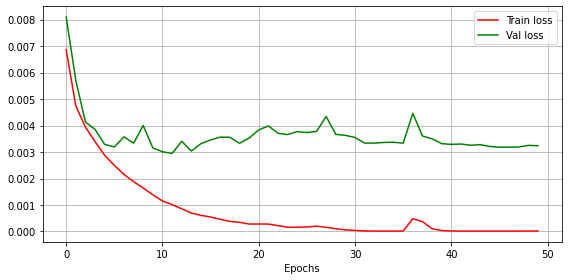

--------------------------------------------------------------------------


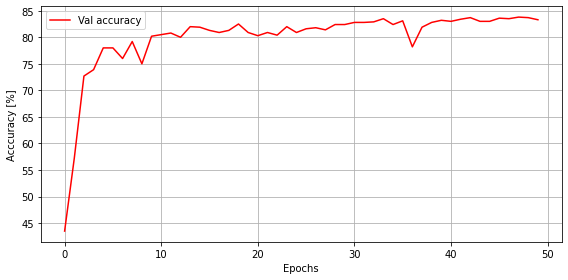

In [ ]:
## Plot validation and training losses
model.eval()

plt.rcParams["figure.figsize"] = (8,4)
plt.figure(2)
plt.plot(loss_train, 'r', label = 'Train loss')
plt.plot(loss_val, 'g', label = 'Val loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
                                                            
print("--------------------------------------------------------------------------")

## Plot validation accuracy
plt.rcParams["figure.figsize"] = (8,4)
plt.figure(3)
plt.plot(accuracy_val, "r", label = 'Val accuracy')
plt.ylabel('Acccuracy [%]')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## Train the model with BN and with early stop
norm_layer = "BN"
num_epochs = 50

## Init model
model = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer).to(device)
model.apply(weights_init)

## Train Model
loss_train, loss_val, accuracy_val =  train_model(model, early_stop = True)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Step [100/245], Loss: 1.1789
Epoch [1/50], Step [200/245], Loss: 1.1214


  2%|▏         | 1/50 [00:29<23:46, 29.11s/it]

Validation accuracy is: 55.1 %
Epoch [2/50], Step [100/245], Loss: 0.9340
Epoch [2/50], Step [200/245], Loss: 0.8864


  4%|▍         | 2/50 [00:58<23:16, 29.10s/it]

Validation accuracy is: 62.4 %
Epoch [3/50], Step [100/245], Loss: 0.6486
Epoch [3/50], Step [200/245], Loss: 0.6127


  6%|▌         | 3/50 [01:26<22:38, 28.90s/it]

Validation accuracy is: 59.5 %
Epoch [4/50], Step [100/245], Loss: 0.7365
Epoch [4/50], Step [200/245], Loss: 0.6389


  8%|▊         | 4/50 [01:56<22:14, 29.00s/it]

Validation accuracy is: 72.0 %
Epoch [5/50], Step [100/245], Loss: 0.6362
Epoch [5/50], Step [200/245], Loss: 0.5727


 10%|█         | 5/50 [02:24<21:43, 28.97s/it]

Validation accuracy is: 73.5 %
Epoch [6/50], Step [100/245], Loss: 0.4692
Epoch [6/50], Step [200/245], Loss: 0.5796


 12%|█▏        | 6/50 [02:53<21:11, 28.89s/it]

Validation accuracy is: 81.7 %
Epoch [7/50], Step [100/245], Loss: 0.4771
Epoch [7/50], Step [200/245], Loss: 0.5411


 14%|█▍        | 7/50 [03:22<20:36, 28.77s/it]

Validation accuracy is: 79.6 %
Epoch [8/50], Step [100/245], Loss: 0.4090
Epoch [8/50], Step [200/245], Loss: 0.3260


 16%|█▌        | 8/50 [03:50<20:00, 28.58s/it]

Validation accuracy is: 77.2 %
Epoch [9/50], Step [100/245], Loss: 0.2511
Epoch [9/50], Step [200/245], Loss: 0.3592


 18%|█▊        | 9/50 [04:18<19:28, 28.50s/it]

Validation accuracy is: 77.6 %
Epoch [10/50], Step [100/245], Loss: 0.2726
Epoch [10/50], Step [200/245], Loss: 0.3566


 20%|██        | 10/50 [04:47<18:58, 28.46s/it]

Validation accuracy is: 79.7 %
Epoch [11/50], Step [100/245], Loss: 0.2071
Epoch [11/50], Step [200/245], Loss: 0.3073


 22%|██▏       | 11/50 [05:15<18:32, 28.53s/it]

Validation accuracy is: 77.2 %
Epoch [12/50], Step [100/245], Loss: 0.1413
Epoch [12/50], Step [200/245], Loss: 0.2070


 24%|██▍       | 12/50 [05:44<18:01, 28.45s/it]

Validation accuracy is: 78.3 %
Epoch [13/50], Step [100/245], Loss: 0.1053
Epoch [13/50], Step [200/245], Loss: 0.1808


 26%|██▌       | 13/50 [06:12<17:29, 28.36s/it]

Validation accuracy is: 79.3 %
Epoch [14/50], Step [100/245], Loss: 0.0850
Epoch [14/50], Step [200/245], Loss: 0.1437


 28%|██▊       | 14/50 [06:40<17:04, 28.45s/it]

Validation accuracy is: 79.1 %
Epoch [15/50], Step [100/245], Loss: 0.0854
Epoch [15/50], Step [200/245], Loss: 0.1091


 30%|███       | 15/50 [07:09<16:35, 28.46s/it]

Validation accuracy is: 80.0 %
Epoch [16/50], Step [100/245], Loss: 0.1013
Epoch [16/50], Step [200/245], Loss: 0.1178


 32%|███▏      | 16/50 [07:37<16:06, 28.42s/it]

Validation accuracy is: 79.3 %
Epoch [17/50], Step [100/245], Loss: 0.0826
Epoch [17/50], Step [200/245], Loss: 0.0865


 34%|███▍      | 17/50 [08:06<15:38, 28.44s/it]

Validation accuracy is: 81.8 %
Epoch [18/50], Step [100/245], Loss: 0.1173
Epoch [18/50], Step [200/245], Loss: 0.1135


 36%|███▌      | 18/50 [08:34<15:08, 28.41s/it]

Validation accuracy is: 81.3 %
Epoch [19/50], Step [100/245], Loss: 0.0525
Epoch [19/50], Step [200/245], Loss: 0.0597


 38%|███▊      | 19/50 [09:02<14:39, 28.38s/it]

Validation accuracy is: 81.8 %
Epoch [20/50], Step [100/245], Loss: 0.0427
Epoch [20/50], Step [200/245], Loss: 0.0580


 40%|████      | 20/50 [09:31<14:10, 28.34s/it]

Validation accuracy is: 82.3 %
Epoch [21/50], Step [100/245], Loss: 0.0540
Epoch [21/50], Step [200/245], Loss: 0.0698


 42%|████▏     | 21/50 [09:59<13:40, 28.28s/it]

Validation accuracy is: 83.8 %
Epoch [22/50], Step [100/245], Loss: 0.0503
Epoch [22/50], Step [200/245], Loss: 0.0571


 44%|████▍     | 22/50 [10:27<13:10, 28.23s/it]

Validation accuracy is: 83.2 %
Epoch [23/50], Step [100/245], Loss: 0.0118
Epoch [23/50], Step [200/245], Loss: 0.0517


 46%|████▌     | 23/50 [10:55<12:42, 28.23s/it]

Validation accuracy is: 83.0 %
Epoch [24/50], Step [100/245], Loss: 0.0420
Epoch [24/50], Step [200/245], Loss: 0.0519


 48%|████▊     | 24/50 [11:23<12:15, 28.30s/it]

Validation accuracy is: 82.9 %
Epoch [25/50], Step [100/245], Loss: 0.0193
Epoch [25/50], Step [200/245], Loss: 0.0316


 50%|█████     | 25/50 [11:52<11:46, 28.25s/it]

Validation accuracy is: 81.6 %
Epoch [26/50], Step [100/245], Loss: 0.0552
Epoch [26/50], Step [200/245], Loss: 0.0595


 52%|█████▏    | 26/50 [12:20<11:16, 28.19s/it]

Validation accuracy is: 82.4 %
Epoch [27/50], Step [100/245], Loss: 0.0192
Epoch [27/50], Step [200/245], Loss: 0.0630


 54%|█████▍    | 27/50 [12:48<10:47, 28.14s/it]

Validation accuracy is: 81.4 %
Epoch [28/50], Step [100/245], Loss: 0.0342
Epoch [28/50], Step [200/245], Loss: 0.0328


 56%|█████▌    | 28/50 [13:16<10:19, 28.17s/it]

Validation accuracy is: 83.4 %
Epoch [29/50], Step [100/245], Loss: 0.0061
Epoch [29/50], Step [200/245], Loss: 0.0159


 58%|█████▊    | 29/50 [13:44<09:51, 28.15s/it]

Validation accuracy is: 84.4 %
Epoch [30/50], Step [100/245], Loss: 0.0147
Epoch [30/50], Step [200/245], Loss: 0.0058


 60%|██████    | 30/50 [14:12<09:23, 28.17s/it]

Validation accuracy is: 85.0 %
Epoch [31/50], Step [100/245], Loss: 0.0045
Epoch [31/50], Step [200/245], Loss: 0.0041


 62%|██████▏   | 31/50 [14:40<08:55, 28.17s/it]

Validation accuracy is: 85.2 %
Epoch [32/50], Step [100/245], Loss: 0.0034
Epoch [32/50], Step [200/245], Loss: 0.0041


 64%|██████▍   | 32/50 [15:09<08:27, 28.19s/it]

Validation accuracy is: 84.6 %
Epoch [33/50], Step [100/245], Loss: 0.0028
Epoch [33/50], Step [200/245], Loss: 0.0023


 66%|██████▌   | 33/50 [15:37<07:59, 28.18s/it]

Validation accuracy is: 85.1 %
Epoch [34/50], Step [100/245], Loss: 0.0019
Epoch [34/50], Step [200/245], Loss: 0.0055


 68%|██████▊   | 34/50 [16:05<07:30, 28.16s/it]

Validation accuracy is: 85.0 %
Epoch [35/50], Step [100/245], Loss: 0.0040
Epoch [35/50], Step [200/245], Loss: 0.0031


 70%|███████   | 35/50 [16:33<07:01, 28.11s/it]

Validation accuracy is: 84.9 %
Epoch [36/50], Step [100/245], Loss: 0.0021
Epoch [36/50], Step [200/245], Loss: 0.0059


 72%|███████▏  | 36/50 [17:01<06:32, 28.07s/it]

Validation accuracy is: 84.4 %
Epoch [37/50], Step [100/245], Loss: 0.0045
Epoch [37/50], Step [200/245], Loss: 0.0046


 74%|███████▍  | 37/50 [17:29<06:06, 28.22s/it]

Validation accuracy is: 83.4 %
Epoch [38/50], Step [100/245], Loss: 0.0083
Epoch [38/50], Step [200/245], Loss: 0.2296


 76%|███████▌  | 38/50 [17:58<05:38, 28.19s/it]

Validation accuracy is: 75.6 %
Epoch [39/50], Step [100/245], Loss: 0.1102
Epoch [39/50], Step [200/245], Loss: 0.0885


 78%|███████▊  | 39/50 [18:26<05:09, 28.15s/it]

Validation accuracy is: 82.3 %
Epoch [40/50], Step [100/245], Loss: 0.0410
Epoch [40/50], Step [200/245], Loss: 0.0219


 80%|████████  | 40/50 [18:54<04:41, 28.10s/it]

Validation accuracy is: 83.8 %
Epoch [41/50], Step [100/245], Loss: 0.0084
Epoch [41/50], Step [200/245], Loss: 0.0069


 82%|████████▏ | 41/50 [19:22<04:12, 28.07s/it]

Validation accuracy is: 83.1 %
Epoch [42/50], Step [100/245], Loss: 0.0036
Epoch [42/50], Step [200/245], Loss: 0.0044


 84%|████████▍ | 42/50 [19:50<03:44, 28.05s/it]

Validation accuracy is: 83.3 %
Epoch [43/50], Step [100/245], Loss: 0.0038
Epoch [43/50], Step [200/245], Loss: 0.0045


 86%|████████▌ | 43/50 [20:18<03:16, 28.05s/it]

Validation accuracy is: 84.0 %
Epoch [44/50], Step [100/245], Loss: 0.0033
Epoch [44/50], Step [200/245], Loss: 0.0053


 88%|████████▊ | 44/50 [20:46<02:48, 28.10s/it]

Validation accuracy is: 84.3 %
Epoch [45/50], Step [100/245], Loss: 0.0018
Epoch [45/50], Step [200/245], Loss: 0.0046


 90%|█████████ | 45/50 [21:14<02:20, 28.06s/it]

Validation accuracy is: 84.6 %
Epoch [46/50], Step [100/245], Loss: 0.0021
Epoch [46/50], Step [200/245], Loss: 0.0028


 92%|█████████▏| 46/50 [21:42<01:52, 28.13s/it]

Validation accuracy is: 84.4 %
Epoch [47/50], Step [100/245], Loss: 0.0033
Epoch [47/50], Step [200/245], Loss: 0.0023


 94%|█████████▍| 47/50 [22:10<01:24, 28.11s/it]

Validation accuracy is: 83.3 %
Epoch [48/50], Step [100/245], Loss: 0.0027
Epoch [48/50], Step [200/245], Loss: 0.0028


 96%|█████████▌| 48/50 [22:38<00:56, 28.04s/it]

Validation accuracy is: 82.9 %
Epoch [49/50], Step [100/245], Loss: 0.0027
Epoch [49/50], Step [200/245], Loss: 0.0032


 98%|█████████▊| 49/50 [23:06<00:28, 28.03s/it]

Validation accuracy is: 82.9 %
Epoch [50/50], Step [100/245], Loss: 0.0030
Epoch [50/50], Step [200/245], Loss: 0.0036


100%|██████████| 50/50 [23:35<00:00, 28.30s/it]

Validation accuracy is: 83.2 %


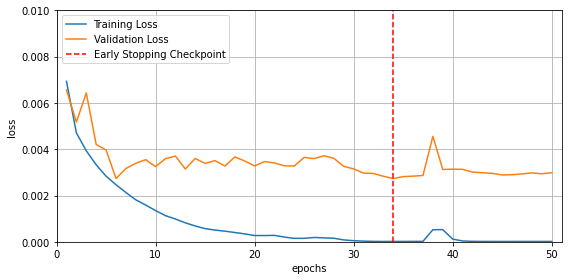

--------------------------------------------------------------------------


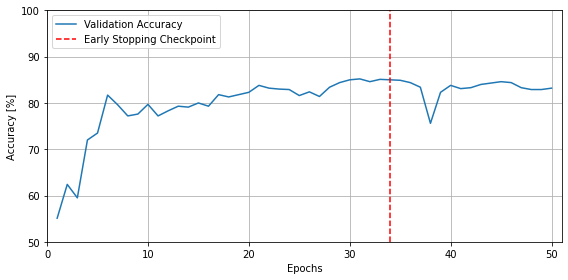

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train)+1),loss_train, label = 'Training Loss')
plt.plot(range(1,len(loss_val)+1),loss_val,label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val.index(min(loss_val))+1 
plt.axvline(minposs, linestyle='--', color='r',label = 'Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.01) # consistent scale
plt.xlim(0, len(loss_train)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## Plot validation accuracy

## Visualize accuracy plot
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(accuracy_val)+1),accuracy_val,label = 'Validation Accuracy')
# find position of lowest validation loss
minposs = loss_val.index(min(loss_val))+1 
plt.axvline(minposs, linestyle='--', color='r',label = 'Early Stopping Checkpoint')
plt.xlabel('Epochs')
plt.ylabel('Accuracy [%]')
plt.ylim(50, 100) # consistent scale
plt.xlim(0, len(loss_train)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Question 3: Implementing the feedforward model


### a)
At this step, we use the *data augmentation* technique in order to create more training data by applying certain transformations to the training set images.

We increase also the number of epochs to 30.

*run the code on top for data augmentation*

In [ ]:
## Training the model with BN and early stop
norm_layer = "BN"
num_epochs = 30

## Init model
model = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer).to(device)
model.apply(weights_init)

## Train Model
loss_train, loss_val, accuracy_val =  train_model(model, early_stop = True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Step [100/245], Loss: 1.4630
Epoch [1/30], Step [200/245], Loss: 1.4294


  3%|▎         | 1/30 [01:01<29:48, 61.68s/it]

Validation accuracy is: 40.7 %
Epoch [2/30], Step [100/245], Loss: 1.1304
Epoch [2/30], Step [200/245], Loss: 0.9921


  7%|▋         | 2/30 [02:03<28:46, 61.67s/it]

Validation accuracy is: 50.9 %
Epoch [3/30], Step [100/245], Loss: 1.0731
Epoch [3/30], Step [200/245], Loss: 0.9850


 10%|█         | 3/30 [03:04<27:35, 61.31s/it]

Validation accuracy is: 68.7 %
Epoch [4/30], Step [100/245], Loss: 0.8171
Epoch [4/30], Step [200/245], Loss: 0.7740


 13%|█▎        | 4/30 [04:04<26:27, 61.04s/it]

Validation accuracy is: 69.2 %
Epoch [5/30], Step [100/245], Loss: 0.6654
Epoch [5/30], Step [200/245], Loss: 0.6667


 17%|█▋        | 5/30 [05:05<25:26, 61.05s/it]

Validation accuracy is: 72.9 %
Epoch [6/30], Step [100/245], Loss: 0.7998
Epoch [6/30], Step [200/245], Loss: 0.7516


 20%|██        | 6/30 [06:06<24:20, 60.87s/it]

Validation accuracy is: 73.9 %
Epoch [7/30], Step [100/245], Loss: 0.7480
Epoch [7/30], Step [200/245], Loss: 0.6933


 23%|██▎       | 7/30 [07:06<23:12, 60.55s/it]

Validation accuracy is: 75.6 %
Epoch [8/30], Step [100/245], Loss: 0.6135
Epoch [8/30], Step [200/245], Loss: 0.6139


 27%|██▋       | 8/30 [08:07<22:13, 60.61s/it]

Validation accuracy is: 74.6 %
Epoch [9/30], Step [100/245], Loss: 0.5609
Epoch [9/30], Step [200/245], Loss: 0.5711


 30%|███       | 9/30 [09:09<21:22, 61.05s/it]

Validation accuracy is: 77.0 %
Epoch [10/30], Step [100/245], Loss: 0.5801
Epoch [10/30], Step [200/245], Loss: 0.5820


 33%|███▎      | 10/30 [10:09<20:16, 60.81s/it]

Validation accuracy is: 79.1 %
Epoch [11/30], Step [100/245], Loss: 0.5444
Epoch [11/30], Step [200/245], Loss: 0.4221


 37%|███▋      | 11/30 [11:09<19:14, 60.74s/it]

Validation accuracy is: 76.4 %
Epoch [12/30], Step [100/245], Loss: 0.4904
Epoch [12/30], Step [200/245], Loss: 0.4183


 40%|████      | 12/30 [12:10<18:10, 60.61s/it]

Validation accuracy is: 79.5 %
Epoch [13/30], Step [100/245], Loss: 0.5002
Epoch [13/30], Step [200/245], Loss: 0.5909


 43%|████▎     | 13/30 [13:10<17:06, 60.38s/it]

Validation accuracy is: 79.6 %
Epoch [14/30], Step [100/245], Loss: 0.4645
Epoch [14/30], Step [200/245], Loss: 0.4059


 47%|████▋     | 14/30 [14:10<16:06, 60.41s/it]

Validation accuracy is: 80.6 %
Epoch [15/30], Step [100/245], Loss: 0.5057
Epoch [15/30], Step [200/245], Loss: 0.3711


 50%|█████     | 15/30 [15:10<15:02, 60.19s/it]

Validation accuracy is: 81.4 %
Epoch [16/30], Step [100/245], Loss: 0.5063
Epoch [16/30], Step [200/245], Loss: 0.5257


 53%|█████▎    | 16/30 [16:10<14:04, 60.29s/it]

Validation accuracy is: 81.3 %
Epoch [17/30], Step [100/245], Loss: 0.4749
Epoch [17/30], Step [200/245], Loss: 0.4370


 57%|█████▋    | 17/30 [17:10<13:01, 60.10s/it]

Validation accuracy is: 81.0 %
Epoch [18/30], Step [100/245], Loss: 0.4580
Epoch [18/30], Step [200/245], Loss: 0.5072


 60%|██████    | 18/30 [18:10<12:01, 60.09s/it]

Validation accuracy is: 81.9 %
Epoch [19/30], Step [100/245], Loss: 0.3601
Epoch [19/30], Step [200/245], Loss: 0.3644


 63%|██████▎   | 19/30 [19:10<11:00, 60.03s/it]

Validation accuracy is: 83.6 %
Epoch [20/30], Step [100/245], Loss: 0.4286
Epoch [20/30], Step [200/245], Loss: 0.3999


 67%|██████▋   | 20/30 [20:09<09:57, 59.76s/it]

Validation accuracy is: 81.3 %
Epoch [21/30], Step [100/245], Loss: 0.3962
Epoch [21/30], Step [200/245], Loss: 0.3953


 70%|███████   | 21/30 [21:08<08:56, 59.66s/it]

Validation accuracy is: 83.3 %
Epoch [22/30], Step [100/245], Loss: 0.4321
Epoch [22/30], Step [200/245], Loss: 0.5182


 73%|███████▎  | 22/30 [22:09<07:59, 60.00s/it]

Validation accuracy is: 83.1 %
Epoch [23/30], Step [100/245], Loss: 0.4505
Epoch [23/30], Step [200/245], Loss: 0.3513


 77%|███████▋  | 23/30 [23:12<07:05, 60.74s/it]

Validation accuracy is: 82.6 %
Epoch [24/30], Step [100/245], Loss: 0.2912
Epoch [24/30], Step [200/245], Loss: 0.4631


 80%|████████  | 24/30 [24:14<06:06, 61.14s/it]

Validation accuracy is: 83.2 %
Epoch [25/30], Step [100/245], Loss: 0.3222
Epoch [25/30], Step [200/245], Loss: 0.2873


 83%|████████▎ | 25/30 [25:15<05:06, 61.26s/it]

Validation accuracy is: 82.2 %
Epoch [26/30], Step [100/245], Loss: 0.2198
Epoch [26/30], Step [200/245], Loss: 0.4624


 87%|████████▋ | 26/30 [26:16<04:04, 61.20s/it]

Validation accuracy is: 82.5 %
Epoch [27/30], Step [100/245], Loss: 0.3419
Epoch [27/30], Step [200/245], Loss: 0.2845


 90%|█████████ | 27/30 [27:18<03:04, 61.38s/it]

Validation accuracy is: 85.3 %
Epoch [28/30], Step [100/245], Loss: 0.2869
Epoch [28/30], Step [200/245], Loss: 0.3255


 93%|█████████▎| 28/30 [28:20<02:03, 61.62s/it]

Validation accuracy is: 82.6 %
Epoch [29/30], Step [100/245], Loss: 0.2446
Epoch [29/30], Step [200/245], Loss: 0.2090


 97%|█████████▋| 29/30 [29:22<01:01, 61.60s/it]

Validation accuracy is: 83.3 %
Epoch [30/30], Step [100/245], Loss: 0.3992
Epoch [30/30], Step [200/245], Loss: 0.3425


100%|██████████| 30/30 [30:24<00:00, 60.80s/it]

Validation accuracy is: 83.1 %


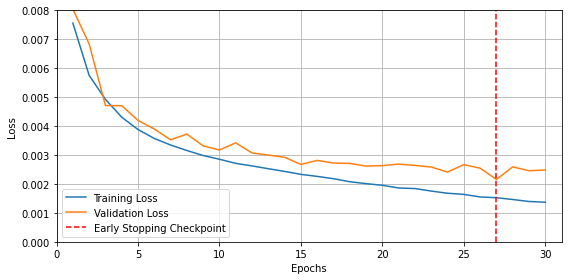

--------------------------------------------------------------------------


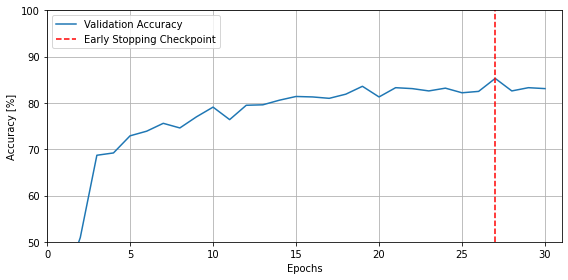

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train)+1), loss_train, label = 'Training Loss')
plt.plot(range(1,len(loss_val)+1), loss_val, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val.index(min(loss_val)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.008) # consistent scale
plt.xlim(0, len(loss_train)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## Plot validation accuracy 
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(accuracy_val)+1), accuracy_val,label = 'Validation Accuracy')
# find position of lowest validation loss
minposs = loss_val.index(min(loss_val)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')
plt.xlabel('Epochs')
plt.ylabel('Accuracy [%]')
plt.ylim(50, 100) # consistent scale
plt.xlim(0, len(loss_train)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In this case, also using the data augmentation we don't see an improvement of the performance, maybe because the combination of different transformations is not so useful.

### b)
In order to reguralize the model to improve generalization, we implement the Droput method, adding the *torch.nn.Dropout* layer between the convolution blocks in the model. 

We need to set one parameter $p$, which is the probability of dropping the input activations. We find the right value in the range [0.1; 0.9].

*remove data augmentation*

### P = 0.1

In [ ]:
## Training the model with BN and early stop
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.1)
model_01 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.1).to(device)
model_01.apply(weights_init)

## Train Model
loss_train_01, loss_val_01, accuracy_val_01 =  train_model(model_01, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.4158
Epoch [1/20], Step [200/245], Loss: 1.1438


  5%|▌         | 1/20 [00:30<09:35, 30.30s/it]

Validation accuracy is: 51.6 %
Epoch [2/20], Step [100/245], Loss: 1.0643
Epoch [2/20], Step [200/245], Loss: 0.8151


 10%|█         | 2/20 [01:00<09:01, 30.07s/it]

Validation accuracy is: 60.9 %
Epoch [3/20], Step [100/245], Loss: 0.7386
Epoch [3/20], Step [200/245], Loss: 0.8749


 15%|█▌        | 3/20 [01:29<08:25, 29.75s/it]

Validation accuracy is: 65.9 %
Epoch [4/20], Step [100/245], Loss: 0.7312
Epoch [4/20], Step [200/245], Loss: 0.7491


 20%|██        | 4/20 [02:01<08:10, 30.65s/it]

Validation accuracy is: 74.0 %
Epoch [5/20], Step [100/245], Loss: 0.6194
Epoch [5/20], Step [200/245], Loss: 0.7065


 25%|██▌       | 5/20 [02:31<07:33, 30.23s/it]

Validation accuracy is: 69.5 %
Epoch [6/20], Step [100/245], Loss: 0.6015
Epoch [6/20], Step [200/245], Loss: 0.5905


 30%|███       | 6/20 [03:00<06:58, 29.88s/it]

Validation accuracy is: 76.1 %
Epoch [7/20], Step [100/245], Loss: 0.4411
Epoch [7/20], Step [200/245], Loss: 0.6530


 35%|███▌      | 7/20 [03:30<06:30, 30.00s/it]

Validation accuracy is: 79.1 %
Epoch [8/20], Step [100/245], Loss: 0.5491
Epoch [8/20], Step [200/245], Loss: 0.5416


 40%|████      | 8/20 [03:59<05:55, 29.64s/it]

Validation accuracy is: 78.7 %
Epoch [9/20], Step [100/245], Loss: 0.4189
Epoch [9/20], Step [200/245], Loss: 0.5508


 45%|████▌     | 9/20 [04:28<05:22, 29.34s/it]

Validation accuracy is: 80.8 %
Epoch [10/20], Step [100/245], Loss: 0.3493
Epoch [10/20], Step [200/245], Loss: 0.4471


 50%|█████     | 10/20 [04:56<04:51, 29.19s/it]

Validation accuracy is: 81.1 %
Epoch [11/20], Step [100/245], Loss: 0.4243
Epoch [11/20], Step [200/245], Loss: 0.4416


 55%|█████▌    | 11/20 [05:25<04:21, 29.09s/it]

Validation accuracy is: 83.8 %
Epoch [12/20], Step [100/245], Loss: 0.3911
Epoch [12/20], Step [200/245], Loss: 0.3508


 60%|██████    | 12/20 [05:54<03:52, 29.06s/it]

Validation accuracy is: 80.5 %
Epoch [13/20], Step [100/245], Loss: 0.3493
Epoch [13/20], Step [200/245], Loss: 0.4315


 65%|██████▌   | 13/20 [06:23<03:23, 29.06s/it]

Validation accuracy is: 82.9 %
Epoch [14/20], Step [100/245], Loss: 0.2948
Epoch [14/20], Step [200/245], Loss: 0.2873


 70%|███████   | 14/20 [06:52<02:53, 28.98s/it]

Validation accuracy is: 82.6 %
Epoch [15/20], Step [100/245], Loss: 0.3735
Epoch [15/20], Step [200/245], Loss: 0.4091


 75%|███████▌  | 15/20 [07:21<02:24, 28.88s/it]

Validation accuracy is: 83.4 %
Epoch [16/20], Step [100/245], Loss: 0.2572
Epoch [16/20], Step [200/245], Loss: 0.3597


 80%|████████  | 16/20 [07:50<01:56, 29.07s/it]

Validation accuracy is: 81.9 %
Epoch [17/20], Step [100/245], Loss: 0.1855
Epoch [17/20], Step [200/245], Loss: 0.4085


 85%|████████▌ | 17/20 [08:19<01:26, 28.91s/it]

Validation accuracy is: 83.4 %
Epoch [18/20], Step [100/245], Loss: 0.1938
Epoch [18/20], Step [200/245], Loss: 0.2323


 90%|█████████ | 18/20 [08:48<00:57, 28.99s/it]

Validation accuracy is: 81.5 %
Epoch [19/20], Step [100/245], Loss: 0.1570
Epoch [19/20], Step [200/245], Loss: 0.2184


 95%|█████████▌| 19/20 [09:17<00:28, 28.99s/it]

Validation accuracy is: 84.6 %
Epoch [20/20], Step [100/245], Loss: 0.2213
Epoch [20/20], Step [200/245], Loss: 0.2689


100%|██████████| 20/20 [09:46<00:00, 29.31s/it]

Validation accuracy is: 85.4 %


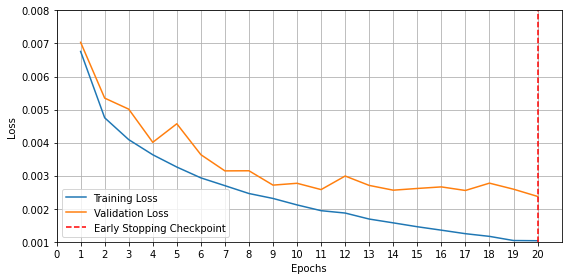

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_01)+1), loss_train_01, label = 'Training Loss')
plt.plot(range(1,len(loss_val_01)+1), loss_val_01, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_01.index(min(loss_val_01)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.001, 0.008) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_01)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 20

In [ ]:
## Check
print("Accuracy at epoch 20:", accuracy_val_01[loss_val_01.index(min(loss_val_01))])

Accuracy at epoch 20: 85.4


### P = 0.2

In [ ]:
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.2)
model_02 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.2).to(device)
model_02.apply(weights_init)

## Train Model
loss_train_02, loss_val_02, accuracy_val_02 =  train_model(model_02, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.4019
Epoch [1/20], Step [200/245], Loss: 1.2088


  5%|▌         | 1/20 [00:29<09:20, 29.52s/it]

Validation accuracy is: 59.3 %
Epoch [2/20], Step [100/245], Loss: 1.0889
Epoch [2/20], Step [200/245], Loss: 0.9286


 10%|█         | 2/20 [00:59<08:53, 29.62s/it]

Validation accuracy is: 58.7 %
Epoch [3/20], Step [100/245], Loss: 0.8163
Epoch [3/20], Step [200/245], Loss: 0.7662


 15%|█▌        | 3/20 [01:28<08:22, 29.58s/it]

Validation accuracy is: 66.5 %
Epoch [4/20], Step [100/245], Loss: 0.8907
Epoch [4/20], Step [200/245], Loss: 0.9199


 20%|██        | 4/20 [01:57<07:50, 29.41s/it]

Validation accuracy is: 70.9 %
Epoch [5/20], Step [100/245], Loss: 0.8755
Epoch [5/20], Step [200/245], Loss: 0.7131


 25%|██▌       | 5/20 [02:27<07:19, 29.31s/it]

Validation accuracy is: 74.1 %
Epoch [6/20], Step [100/245], Loss: 0.6933
Epoch [6/20], Step [200/245], Loss: 0.7152


 30%|███       | 6/20 [02:55<06:48, 29.19s/it]

Validation accuracy is: 77.1 %
Epoch [7/20], Step [100/245], Loss: 0.7142
Epoch [7/20], Step [200/245], Loss: 0.5164


 35%|███▌      | 7/20 [03:24<06:18, 29.08s/it]

Validation accuracy is: 76.4 %
Epoch [8/20], Step [100/245], Loss: 0.5232
Epoch [8/20], Step [200/245], Loss: 0.4739


 40%|████      | 8/20 [03:54<05:49, 29.14s/it]

Validation accuracy is: 82.4 %
Epoch [9/20], Step [100/245], Loss: 0.5774
Epoch [9/20], Step [200/245], Loss: 0.6525


 45%|████▌     | 9/20 [04:22<05:18, 29.00s/it]

Validation accuracy is: 82.0 %
Epoch [10/20], Step [100/245], Loss: 0.4127
Epoch [10/20], Step [200/245], Loss: 0.4892


 50%|█████     | 10/20 [04:51<04:49, 28.91s/it]

Validation accuracy is: 81.1 %
Epoch [11/20], Step [100/245], Loss: 0.4973
Epoch [11/20], Step [200/245], Loss: 0.6345


 55%|█████▌    | 11/20 [05:20<04:19, 28.86s/it]

Validation accuracy is: 82.1 %
Epoch [12/20], Step [100/245], Loss: 0.5228
Epoch [12/20], Step [200/245], Loss: 0.4868


 60%|██████    | 12/20 [05:48<03:50, 28.80s/it]

Validation accuracy is: 81.1 %
Epoch [13/20], Step [100/245], Loss: 0.4382
Epoch [13/20], Step [200/245], Loss: 0.6521


 65%|██████▌   | 13/20 [06:17<03:21, 28.79s/it]

Validation accuracy is: 81.6 %
Epoch [14/20], Step [100/245], Loss: 0.3542
Epoch [14/20], Step [200/245], Loss: 0.4112


 70%|███████   | 14/20 [06:46<02:52, 28.81s/it]

Validation accuracy is: 83.2 %
Epoch [15/20], Step [100/245], Loss: 0.4331
Epoch [15/20], Step [200/245], Loss: 0.4328


 75%|███████▌  | 15/20 [07:15<02:23, 28.72s/it]

Validation accuracy is: 82.9 %
Epoch [16/20], Step [100/245], Loss: 0.3531
Epoch [16/20], Step [200/245], Loss: 0.3712


 80%|████████  | 16/20 [07:43<01:54, 28.69s/it]

Validation accuracy is: 84.4 %
Epoch [17/20], Step [100/245], Loss: 0.3766
Epoch [17/20], Step [200/245], Loss: 0.3145


 85%|████████▌ | 17/20 [08:12<01:25, 28.65s/it]

Validation accuracy is: 84.9 %
Epoch [18/20], Step [100/245], Loss: 0.3222
Epoch [18/20], Step [200/245], Loss: 0.2929


 90%|█████████ | 18/20 [08:40<00:57, 28.62s/it]

Validation accuracy is: 85.2 %
Epoch [19/20], Step [100/245], Loss: 0.3692
Epoch [19/20], Step [200/245], Loss: 0.3739


 95%|█████████▌| 19/20 [09:09<00:28, 28.55s/it]

Validation accuracy is: 85.5 %
Epoch [20/20], Step [100/245], Loss: 0.2443
Epoch [20/20], Step [200/245], Loss: 0.2699


100%|██████████| 20/20 [09:38<00:00, 28.91s/it]

Validation accuracy is: 83.7 %


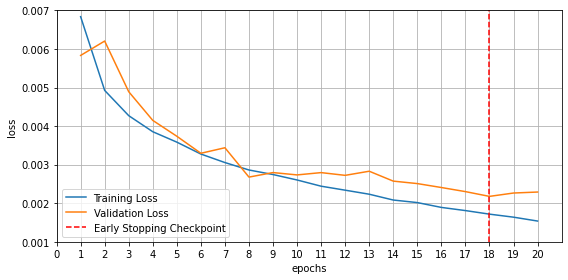

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_02)+1), loss_train_02, label = 'Training Loss')
plt.plot(range(1,len(loss_val_02)+1), loss_val_02, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_02.index(min(loss_val_02)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0.001, 0.007) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_02)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 18 

In [ ]:
## Check
print("Accuracy at epoch 18:", accuracy_val_02[loss_val_02.index(min(loss_val_02))])

Accuracy at epoch 18: 85.2


### P = 0.3

In [ ]:
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.3)
model_03 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.3).to(device)
model_03.apply(weights_init)

## Train Model
loss_train_03, loss_val_03, accuracy_val_03 =  train_model(model_03, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.5087
Epoch [1/20], Step [200/245], Loss: 1.2226


  5%|▌         | 1/20 [00:29<09:20, 29.48s/it]

Validation accuracy is: 50.6 %
Epoch [2/20], Step [100/245], Loss: 1.0123
Epoch [2/20], Step [200/245], Loss: 0.9717


 10%|█         | 2/20 [00:58<08:48, 29.36s/it]

Validation accuracy is: 65.4 %
Epoch [3/20], Step [100/245], Loss: 0.8219
Epoch [3/20], Step [200/245], Loss: 0.8005


 15%|█▌        | 3/20 [01:28<08:22, 29.56s/it]

Validation accuracy is: 69.3 %
Epoch [4/20], Step [100/245], Loss: 0.7411
Epoch [4/20], Step [200/245], Loss: 0.7063


 20%|██        | 4/20 [01:58<07:52, 29.56s/it]

Validation accuracy is: 65.7 %
Epoch [5/20], Step [100/245], Loss: 0.8275
Epoch [5/20], Step [200/245], Loss: 0.9581


 25%|██▌       | 5/20 [02:27<07:22, 29.52s/it]

Validation accuracy is: 75.8 %
Epoch [6/20], Step [100/245], Loss: 0.7010
Epoch [6/20], Step [200/245], Loss: 0.9134


 30%|███       | 6/20 [02:56<06:50, 29.31s/it]

Validation accuracy is: 74.3 %
Epoch [7/20], Step [100/245], Loss: 0.6268
Epoch [7/20], Step [200/245], Loss: 0.5785


 35%|███▌      | 7/20 [03:25<06:19, 29.21s/it]

Validation accuracy is: 77.2 %
Epoch [8/20], Step [100/245], Loss: 0.6421
Epoch [8/20], Step [200/245], Loss: 0.6014


 40%|████      | 8/20 [03:54<05:49, 29.09s/it]

Validation accuracy is: 76.2 %
Epoch [9/20], Step [100/245], Loss: 0.6506
Epoch [9/20], Step [200/245], Loss: 0.6027


 45%|████▌     | 9/20 [04:23<05:19, 29.05s/it]

Validation accuracy is: 78.4 %
Epoch [10/20], Step [100/245], Loss: 0.6019
Epoch [10/20], Step [200/245], Loss: 0.6138


 50%|█████     | 10/20 [04:54<04:57, 29.80s/it]

Validation accuracy is: 81.8 %
Epoch [11/20], Step [100/245], Loss: 0.6033
Epoch [11/20], Step [200/245], Loss: 0.6055


 55%|█████▌    | 11/20 [05:23<04:25, 29.52s/it]

Validation accuracy is: 79.8 %
Epoch [12/20], Step [100/245], Loss: 0.7067
Epoch [12/20], Step [200/245], Loss: 0.6787


 60%|██████    | 12/20 [05:52<03:54, 29.27s/it]

Validation accuracy is: 80.4 %
Epoch [13/20], Step [100/245], Loss: 0.5606
Epoch [13/20], Step [200/245], Loss: 0.5223


 65%|██████▌   | 13/20 [06:21<03:23, 29.10s/it]

Validation accuracy is: 80.4 %
Epoch [14/20], Step [100/245], Loss: 0.4842
Epoch [14/20], Step [200/245], Loss: 0.4557


 70%|███████   | 14/20 [06:49<02:54, 29.04s/it]

Validation accuracy is: 81.8 %
Epoch [15/20], Step [100/245], Loss: 0.4655
Epoch [15/20], Step [200/245], Loss: 0.4620


 75%|███████▌  | 15/20 [07:18<02:24, 28.94s/it]

Validation accuracy is: 83.1 %
Epoch [16/20], Step [100/245], Loss: 0.5299
Epoch [16/20], Step [200/245], Loss: 0.5081


 80%|████████  | 16/20 [07:47<01:56, 29.01s/it]

Validation accuracy is: 83.9 %
Epoch [17/20], Step [100/245], Loss: 0.5983
Epoch [17/20], Step [200/245], Loss: 0.3797


 85%|████████▌ | 17/20 [08:16<01:26, 28.91s/it]

Validation accuracy is: 82.9 %
Epoch [18/20], Step [100/245], Loss: 0.5140
Epoch [18/20], Step [200/245], Loss: 0.5076


 90%|█████████ | 18/20 [08:45<00:57, 28.88s/it]

Validation accuracy is: 84.6 %
Epoch [19/20], Step [100/245], Loss: 0.3090
Epoch [19/20], Step [200/245], Loss: 0.4731


 95%|█████████▌| 19/20 [09:13<00:28, 28.82s/it]

Validation accuracy is: 85.3 %
Epoch [20/20], Step [100/245], Loss: 0.3367
Epoch [20/20], Step [200/245], Loss: 0.5888


100%|██████████| 20/20 [09:42<00:00, 29.13s/it]

Validation accuracy is: 85.1 %


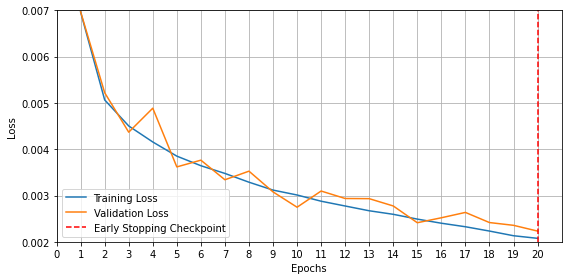

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_03)+1), loss_train_03, label = 'Training Loss')
plt.plot(range(1,len(loss_val_03)+1), loss_val_03, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_03.index(min(loss_val_03)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.002, 0.007) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_03)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 20

In [ ]:
## Check
print("Accuracy at epoch 20:", accuracy_val_03[loss_val_03.index(min(loss_val_03))])

Accuracy at epoch 20: 85.1


### P = 0.4

In [ ]:
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.4)
model_04 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.4).to(device)
model_04.apply(weights_init)

## Train Model
loss_train_04, loss_val_04, accuracy_val_04 =  train_model(model_04, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.4979
Epoch [1/20], Step [200/245], Loss: 1.1234


  5%|▌         | 1/20 [00:29<09:20, 29.48s/it]

Validation accuracy is: 51.4 %
Epoch [2/20], Step [100/245], Loss: 1.0363
Epoch [2/20], Step [200/245], Loss: 1.0955


 10%|█         | 2/20 [00:59<08:53, 29.62s/it]

Validation accuracy is: 65.2 %
Epoch [3/20], Step [100/245], Loss: 0.8682
Epoch [3/20], Step [200/245], Loss: 0.9476


 15%|█▌        | 3/20 [01:28<08:18, 29.31s/it]

Validation accuracy is: 68.2 %
Epoch [4/20], Step [100/245], Loss: 0.9090
Epoch [4/20], Step [200/245], Loss: 0.8850


 20%|██        | 4/20 [01:57<07:48, 29.29s/it]

Validation accuracy is: 67.3 %
Epoch [5/20], Step [100/245], Loss: 0.7993
Epoch [5/20], Step [200/245], Loss: 0.8009


 25%|██▌       | 5/20 [02:26<07:19, 29.27s/it]

Validation accuracy is: 72.2 %
Epoch [6/20], Step [100/245], Loss: 0.7904
Epoch [6/20], Step [200/245], Loss: 0.8261


 30%|███       | 6/20 [02:56<06:50, 29.33s/it]

Validation accuracy is: 78.8 %
Epoch [7/20], Step [100/245], Loss: 0.7862
Epoch [7/20], Step [200/245], Loss: 0.7270


 35%|███▌      | 7/20 [03:25<06:19, 29.22s/it]

Validation accuracy is: 74.4 %
Epoch [8/20], Step [100/245], Loss: 0.5690
Epoch [8/20], Step [200/245], Loss: 0.6303


 40%|████      | 8/20 [03:54<05:50, 29.18s/it]

Validation accuracy is: 78.2 %
Epoch [9/20], Step [100/245], Loss: 0.6008
Epoch [9/20], Step [200/245], Loss: 0.8014


 45%|████▌     | 9/20 [04:23<05:20, 29.15s/it]

Validation accuracy is: 79.3 %
Epoch [10/20], Step [100/245], Loss: 0.7176
Epoch [10/20], Step [200/245], Loss: 0.6125


 50%|█████     | 10/20 [04:52<04:51, 29.10s/it]

Validation accuracy is: 78.0 %
Epoch [11/20], Step [100/245], Loss: 0.6554
Epoch [11/20], Step [200/245], Loss: 0.5599


 55%|█████▌    | 11/20 [05:21<04:21, 29.08s/it]

Validation accuracy is: 81.2 %
Epoch [12/20], Step [100/245], Loss: 0.5578
Epoch [12/20], Step [200/245], Loss: 0.5733


 60%|██████    | 12/20 [05:50<03:53, 29.13s/it]

Validation accuracy is: 80.4 %
Epoch [13/20], Step [100/245], Loss: 0.7281
Epoch [13/20], Step [200/245], Loss: 0.6247


 65%|██████▌   | 13/20 [06:19<03:23, 29.06s/it]

Validation accuracy is: 79.4 %
Epoch [14/20], Step [100/245], Loss: 0.5702
Epoch [14/20], Step [200/245], Loss: 0.6390


 70%|███████   | 14/20 [06:48<02:53, 28.98s/it]

Validation accuracy is: 78.7 %
Epoch [15/20], Step [100/245], Loss: 0.6166
Epoch [15/20], Step [200/245], Loss: 0.5900


 75%|███████▌  | 15/20 [07:16<02:24, 28.91s/it]

Validation accuracy is: 83.1 %
Epoch [16/20], Step [100/245], Loss: 0.5208
Epoch [16/20], Step [200/245], Loss: 0.6978


 80%|████████  | 16/20 [07:45<01:55, 28.91s/it]

Validation accuracy is: 83.5 %
Epoch [17/20], Step [100/245], Loss: 0.4902
Epoch [17/20], Step [200/245], Loss: 0.5991


 85%|████████▌ | 17/20 [08:15<01:26, 28.98s/it]

Validation accuracy is: 82.7 %
Epoch [18/20], Step [100/245], Loss: 0.4849
Epoch [18/20], Step [200/245], Loss: 0.5412


 90%|█████████ | 18/20 [08:43<00:57, 28.96s/it]

Validation accuracy is: 81.0 %
Epoch [19/20], Step [100/245], Loss: 0.4654
Epoch [19/20], Step [200/245], Loss: 0.5831


 95%|█████████▌| 19/20 [09:12<00:28, 28.91s/it]

Validation accuracy is: 84.3 %
Epoch [20/20], Step [100/245], Loss: 0.5031
Epoch [20/20], Step [200/245], Loss: 0.5705


100%|██████████| 20/20 [09:41<00:00, 29.08s/it]

Validation accuracy is: 83.9 %


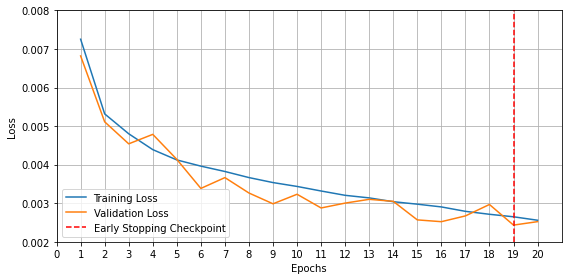

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_04)+1), loss_train_04, label = 'Training Loss')
plt.plot(range(1,len(loss_val_04)+1), loss_val_04, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_04.index(min(loss_val_04)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.002, 0.008) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_04)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 19

In [ ]:
## Check
print("Accuracy at epoch 19:", accuracy_val_04[loss_val_04.index(min(loss_val_04))])

Accuracy at epoch 19: 84.3


### P = 0.5

In [ ]:
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.5)
model_05 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.5).to(device)
model_05.apply(weights_init)

## Train Model
loss_train_05, loss_val_05, accuracy_val_05 =  train_model(model_05, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.4149
Epoch [1/20], Step [200/245], Loss: 1.2939


  5%|▌         | 1/20 [00:29<09:19, 29.43s/it]

Validation accuracy is: 56.9 %
Epoch [2/20], Step [100/245], Loss: 1.3594
Epoch [2/20], Step [200/245], Loss: 1.2188


 10%|█         | 2/20 [00:58<08:49, 29.42s/it]

Validation accuracy is: 63.1 %
Epoch [3/20], Step [100/245], Loss: 0.8987
Epoch [3/20], Step [200/245], Loss: 1.1150


 15%|█▌        | 3/20 [01:28<08:21, 29.53s/it]

Validation accuracy is: 66.0 %
Epoch [4/20], Step [100/245], Loss: 0.9669
Epoch [4/20], Step [200/245], Loss: 0.8609


 20%|██        | 4/20 [01:57<07:50, 29.39s/it]

Validation accuracy is: 66.5 %
Epoch [5/20], Step [100/245], Loss: 0.8973
Epoch [5/20], Step [200/245], Loss: 0.8465


 25%|██▌       | 5/20 [02:26<07:19, 29.31s/it]

Validation accuracy is: 63.7 %
Epoch [6/20], Step [100/245], Loss: 0.8678
Epoch [6/20], Step [200/245], Loss: 0.8448


 30%|███       | 6/20 [02:55<06:48, 29.21s/it]

Validation accuracy is: 66.8 %
Epoch [7/20], Step [100/245], Loss: 0.9549
Epoch [7/20], Step [200/245], Loss: 0.8065


 35%|███▌      | 7/20 [03:25<06:19, 29.20s/it]

Validation accuracy is: 71.3 %
Epoch [8/20], Step [100/245], Loss: 0.7688
Epoch [8/20], Step [200/245], Loss: 0.7431


 40%|████      | 8/20 [03:54<05:51, 29.26s/it]

Validation accuracy is: 71.9 %
Epoch [9/20], Step [100/245], Loss: 0.8772
Epoch [9/20], Step [200/245], Loss: 0.7244


 45%|████▌     | 9/20 [04:23<05:21, 29.19s/it]

Validation accuracy is: 70.5 %
Epoch [10/20], Step [100/245], Loss: 0.7435
Epoch [10/20], Step [200/245], Loss: 0.7313


 50%|█████     | 10/20 [04:52<04:51, 29.12s/it]

Validation accuracy is: 75.0 %
Epoch [11/20], Step [100/245], Loss: 0.6686
Epoch [11/20], Step [200/245], Loss: 0.7418


 55%|█████▌    | 11/20 [05:21<04:21, 29.10s/it]

Validation accuracy is: 76.7 %
Epoch [12/20], Step [100/245], Loss: 0.7587
Epoch [12/20], Step [200/245], Loss: 0.7848


 60%|██████    | 12/20 [05:50<03:52, 29.05s/it]

Validation accuracy is: 76.1 %
Epoch [13/20], Step [100/245], Loss: 0.5196
Epoch [13/20], Step [200/245], Loss: 0.7174


 65%|██████▌   | 13/20 [06:19<03:23, 29.02s/it]

Validation accuracy is: 75.1 %
Epoch [14/20], Step [100/245], Loss: 0.6763
Epoch [14/20], Step [200/245], Loss: 0.8145


 70%|███████   | 14/20 [06:48<02:54, 29.05s/it]

Validation accuracy is: 73.7 %
Epoch [15/20], Step [100/245], Loss: 0.6167
Epoch [15/20], Step [200/245], Loss: 0.6922


 75%|███████▌  | 15/20 [07:17<02:25, 29.00s/it]

Validation accuracy is: 78.2 %
Epoch [16/20], Step [100/245], Loss: 0.6641
Epoch [16/20], Step [200/245], Loss: 0.5997


 80%|████████  | 16/20 [07:46<01:55, 28.98s/it]

Validation accuracy is: 78.3 %
Epoch [17/20], Step [100/245], Loss: 0.6042
Epoch [17/20], Step [200/245], Loss: 0.8198


 85%|████████▌ | 17/20 [08:15<01:26, 28.94s/it]

Validation accuracy is: 79.6 %
Epoch [18/20], Step [100/245], Loss: 0.6881
Epoch [18/20], Step [200/245], Loss: 0.6864


 90%|█████████ | 18/20 [08:44<00:57, 28.91s/it]

Validation accuracy is: 79.4 %
Epoch [19/20], Step [100/245], Loss: 0.4670
Epoch [19/20], Step [200/245], Loss: 0.6609


 95%|█████████▌| 19/20 [09:12<00:28, 28.89s/it]

Validation accuracy is: 81.6 %
Epoch [20/20], Step [100/245], Loss: 0.6046
Epoch [20/20], Step [200/245], Loss: 0.7036


100%|██████████| 20/20 [09:42<00:00, 29.11s/it]

Validation accuracy is: 80.8 %


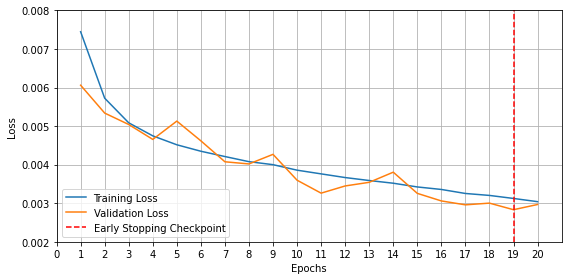

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_05)+1), loss_train_05, label = 'Training Loss')
plt.plot(range(1,len(loss_val_05)+1), loss_val_05, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_05.index(min(loss_val_05)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.002, 0.008) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_05)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 19

In [ ]:
## Check
print("Accuracy at epoch 19:", accuracy_val_05[loss_val_05.index(min(loss_val_05))])

Accuracy at epoch 19: 81.6


### P = 0.6

In [ ]:
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.6)
model_06 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.6).to(device)
model_06.apply(weights_init)

## Train Model
loss_train_06, loss_val_06, accuracy_val_06 =  train_model(model_06, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.6384
Epoch [1/20], Step [200/245], Loss: 1.2080


  5%|▌         | 1/20 [00:29<09:21, 29.55s/it]

Validation accuracy is: 48.8 %
Epoch [2/20], Step [100/245], Loss: 1.1870
Epoch [2/20], Step [200/245], Loss: 1.1165


 10%|█         | 2/20 [00:58<08:46, 29.25s/it]

Validation accuracy is: 55.1 %
Epoch [3/20], Step [100/245], Loss: 1.1734
Epoch [3/20], Step [200/245], Loss: 0.9729


 15%|█▌        | 3/20 [01:27<08:16, 29.19s/it]

Validation accuracy is: 64.9 %
Epoch [4/20], Step [100/245], Loss: 1.0110
Epoch [4/20], Step [200/245], Loss: 1.0655


 20%|██        | 4/20 [01:57<07:49, 29.32s/it]

Validation accuracy is: 63.9 %
Epoch [5/20], Step [100/245], Loss: 1.0029
Epoch [5/20], Step [200/245], Loss: 0.8201


 25%|██▌       | 5/20 [02:26<07:18, 29.26s/it]

Validation accuracy is: 64.2 %
Epoch [6/20], Step [100/245], Loss: 1.0622
Epoch [6/20], Step [200/245], Loss: 0.9444


 30%|███       | 6/20 [02:55<06:48, 29.17s/it]

Validation accuracy is: 63.3 %
Epoch [7/20], Step [100/245], Loss: 0.9218
Epoch [7/20], Step [200/245], Loss: 0.9299


 35%|███▌      | 7/20 [03:24<06:18, 29.13s/it]

Validation accuracy is: 65.6 %
Epoch [8/20], Step [100/245], Loss: 0.8359
Epoch [8/20], Step [200/245], Loss: 0.9251


 40%|████      | 8/20 [03:53<05:48, 29.08s/it]

Validation accuracy is: 67.5 %
Epoch [9/20], Step [100/245], Loss: 1.0587
Epoch [9/20], Step [200/245], Loss: 0.8589


 45%|████▌     | 9/20 [04:22<05:19, 29.08s/it]

Validation accuracy is: 69.2 %
Epoch [10/20], Step [100/245], Loss: 0.9487
Epoch [10/20], Step [200/245], Loss: 0.8280


 50%|█████     | 10/20 [04:51<04:51, 29.19s/it]

Validation accuracy is: 72.0 %
Epoch [11/20], Step [100/245], Loss: 0.8444
Epoch [11/20], Step [200/245], Loss: 0.7754


 55%|█████▌    | 11/20 [05:20<04:21, 29.11s/it]

Validation accuracy is: 69.9 %
Epoch [12/20], Step [100/245], Loss: 0.8434
Epoch [12/20], Step [200/245], Loss: 0.7861


 60%|██████    | 12/20 [05:49<03:52, 29.09s/it]

Validation accuracy is: 75.2 %
Epoch [13/20], Step [100/245], Loss: 0.7387
Epoch [13/20], Step [200/245], Loss: 0.8334


 65%|██████▌   | 13/20 [06:18<03:23, 29.06s/it]

Validation accuracy is: 70.6 %
Epoch [14/20], Step [100/245], Loss: 0.9005
Epoch [14/20], Step [200/245], Loss: 0.7059


 70%|███████   | 14/20 [06:47<02:54, 29.06s/it]

Validation accuracy is: 75.1 %
Epoch [15/20], Step [100/245], Loss: 0.8440
Epoch [15/20], Step [200/245], Loss: 0.7738


 75%|███████▌  | 15/20 [07:16<02:25, 29.06s/it]

Validation accuracy is: 72.5 %
Epoch [16/20], Step [100/245], Loss: 0.8504
Epoch [16/20], Step [200/245], Loss: 0.7917


 80%|████████  | 16/20 [07:46<01:56, 29.19s/it]

Validation accuracy is: 72.9 %
Epoch [17/20], Step [100/245], Loss: 0.8161
Epoch [17/20], Step [200/245], Loss: 0.8840


 85%|████████▌ | 17/20 [08:15<01:27, 29.18s/it]

Validation accuracy is: 70.2 %
Epoch [18/20], Step [100/245], Loss: 0.8096
Epoch [18/20], Step [200/245], Loss: 0.8412


 90%|█████████ | 18/20 [08:44<00:58, 29.14s/it]

Validation accuracy is: 75.8 %
Epoch [19/20], Step [100/245], Loss: 0.7847
Epoch [19/20], Step [200/245], Loss: 0.7797


 95%|█████████▌| 19/20 [09:13<00:29, 29.07s/it]

Validation accuracy is: 75.6 %
Epoch [20/20], Step [100/245], Loss: 0.6672
Epoch [20/20], Step [200/245], Loss: 0.8674


100%|██████████| 20/20 [09:42<00:00, 29.13s/it]

Validation accuracy is: 72.8 %


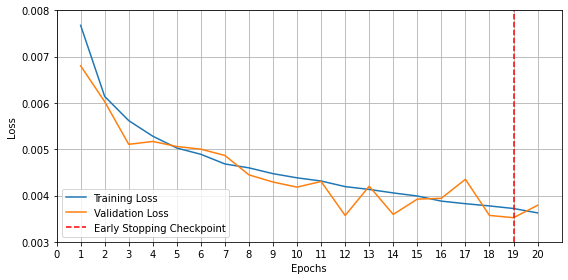

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_06)+1), loss_train_06, label = 'Training Loss')
plt.plot(range(1,len(loss_val_06)+1), loss_val_06, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_06.index(min(loss_val_06)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.003, 0.008) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_06)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 19

In [ ]:
## Check
print("Accuracy at epoch 19", accuracy_val_06[loss_val_06.index(min(loss_val_06))])

Accuracy at epoch 19 75.6


### P = 0.7

In [ ]:
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.7)
model_07 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.7).to(device)
model_07.apply(weights_init)

## Train Model
loss_train_07, loss_val_07, accuracy_val_07 =  train_model(model_07, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.6938
Epoch [1/20], Step [200/245], Loss: 1.4646


  5%|▌         | 1/20 [00:29<09:23, 29.64s/it]

Validation accuracy is: 36.1 %
Epoch [2/20], Step [100/245], Loss: 1.3532
Epoch [2/20], Step [200/245], Loss: 1.2375


 10%|█         | 2/20 [00:58<08:48, 29.38s/it]

Validation accuracy is: 50.5 %
Epoch [3/20], Step [100/245], Loss: 1.2923
Epoch [3/20], Step [200/245], Loss: 1.3545


 15%|█▌        | 3/20 [01:28<08:17, 29.28s/it]

Validation accuracy is: 53.0 %
Epoch [4/20], Step [100/245], Loss: 1.1383
Epoch [4/20], Step [200/245], Loss: 1.1452


 20%|██        | 4/20 [01:57<07:47, 29.21s/it]

Validation accuracy is: 51.1 %
Epoch [5/20], Step [100/245], Loss: 1.1659
Epoch [5/20], Step [200/245], Loss: 1.3143


 25%|██▌       | 5/20 [02:26<07:17, 29.16s/it]

Validation accuracy is: 59.4 %
Epoch [6/20], Step [100/245], Loss: 1.1445
Epoch [6/20], Step [200/245], Loss: 1.0035


 30%|███       | 6/20 [02:55<06:47, 29.13s/it]

Validation accuracy is: 57.4 %
Epoch [7/20], Step [100/245], Loss: 1.2286
Epoch [7/20], Step [200/245], Loss: 1.1416


 35%|███▌      | 7/20 [03:24<06:19, 29.22s/it]

Validation accuracy is: 54.9 %
Epoch [8/20], Step [100/245], Loss: 1.0474
Epoch [8/20], Step [200/245], Loss: 1.0611


 40%|████      | 8/20 [03:53<05:50, 29.17s/it]

Validation accuracy is: 61.0 %
Epoch [9/20], Step [100/245], Loss: 1.2188
Epoch [9/20], Step [200/245], Loss: 0.9467


 45%|████▌     | 9/20 [04:22<05:20, 29.16s/it]

Validation accuracy is: 62.5 %
Epoch [10/20], Step [100/245], Loss: 1.1903
Epoch [10/20], Step [200/245], Loss: 0.9736


 50%|█████     | 10/20 [04:51<04:51, 29.14s/it]

Validation accuracy is: 59.4 %
Epoch [11/20], Step [100/245], Loss: 1.1327
Epoch [11/20], Step [200/245], Loss: 0.9973


 55%|█████▌    | 11/20 [05:21<04:22, 29.13s/it]

Validation accuracy is: 63.4 %
Epoch [12/20], Step [100/245], Loss: 1.0092
Epoch [12/20], Step [200/245], Loss: 1.0366


 60%|██████    | 12/20 [05:50<03:53, 29.21s/it]

Validation accuracy is: 63.5 %
Epoch [13/20], Step [100/245], Loss: 0.9494
Epoch [13/20], Step [200/245], Loss: 1.0509


 65%|██████▌   | 13/20 [06:19<03:24, 29.16s/it]

Validation accuracy is: 60.3 %
Epoch [14/20], Step [100/245], Loss: 0.9896
Epoch [14/20], Step [200/245], Loss: 0.8344


 70%|███████   | 14/20 [06:48<02:54, 29.16s/it]

Validation accuracy is: 66.6 %
Epoch [15/20], Step [100/245], Loss: 1.0249
Epoch [15/20], Step [200/245], Loss: 0.8206


 75%|███████▌  | 15/20 [07:17<02:25, 29.18s/it]

Validation accuracy is: 66.5 %
Epoch [16/20], Step [100/245], Loss: 0.8320
Epoch [16/20], Step [200/245], Loss: 0.9228


 80%|████████  | 16/20 [07:47<01:56, 29.18s/it]

Validation accuracy is: 66.5 %
Epoch [17/20], Step [100/245], Loss: 0.9321
Epoch [17/20], Step [200/245], Loss: 0.9069


 85%|████████▌ | 17/20 [08:16<01:27, 29.23s/it]

Validation accuracy is: 63.2 %
Epoch [18/20], Step [100/245], Loss: 0.9087
Epoch [18/20], Step [200/245], Loss: 0.8242


 90%|█████████ | 18/20 [08:46<00:58, 29.36s/it]

Validation accuracy is: 66.0 %
Epoch [19/20], Step [100/245], Loss: 0.8419
Epoch [19/20], Step [200/245], Loss: 0.8088


 95%|█████████▌| 19/20 [09:15<00:29, 29.34s/it]

Validation accuracy is: 67.9 %
Epoch [20/20], Step [100/245], Loss: 0.9283
Epoch [20/20], Step [200/245], Loss: 0.9543


100%|██████████| 20/20 [09:44<00:00, 29.25s/it]

Validation accuracy is: 67.2 %


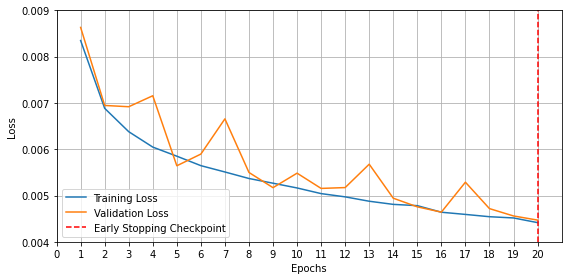

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_07)+1), loss_train_07, label = 'Training Loss')
plt.plot(range(1,len(loss_val_07)+1), loss_val_07, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_07.index(min(loss_val_07)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.004, 0.009) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_07)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 20

In [ ]:
## Check
print("Accuracy at epoch 20:", accuracy_val_07[loss_val_07.index(min(loss_val_07))])

Accuracy at epoch 20: 67.2


### P = 0.8

In [ ]:
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.8)
model_08 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.8).to(device)
model_08.apply(weights_init)

## Train Model
loss_train_08, loss_val_08, accuracy_val_08 =  train_model(model_08, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 1.7509
Epoch [1/20], Step [200/245], Loss: 1.8006


  5%|▌         | 1/20 [00:29<09:26, 29.79s/it]

Validation accuracy is: 23.5 %
Epoch [2/20], Step [100/245], Loss: 1.5570
Epoch [2/20], Step [200/245], Loss: 1.5613


 10%|█         | 2/20 [00:59<08:58, 29.89s/it]

Validation accuracy is: 17.3 %
Epoch [3/20], Step [100/245], Loss: 1.4160
Epoch [3/20], Step [200/245], Loss: 1.5663


 15%|█▌        | 3/20 [01:29<08:23, 29.61s/it]

Validation accuracy is: 16.9 %
Epoch [4/20], Step [100/245], Loss: 1.5993
Epoch [4/20], Step [200/245], Loss: 1.3950


 20%|██        | 4/20 [01:58<07:51, 29.50s/it]

Validation accuracy is: 22.6 %
Epoch [5/20], Step [100/245], Loss: 1.4654
Epoch [5/20], Step [200/245], Loss: 1.5058


 25%|██▌       | 5/20 [02:28<07:24, 29.63s/it]

Validation accuracy is: 36.1 %
Epoch [6/20], Step [100/245], Loss: 1.3872
Epoch [6/20], Step [200/245], Loss: 1.4860


 30%|███       | 6/20 [02:57<06:55, 29.68s/it]

Validation accuracy is: 30.4 %
Epoch [7/20], Step [100/245], Loss: 1.3748
Epoch [7/20], Step [200/245], Loss: 1.4315


 35%|███▌      | 7/20 [03:28<06:29, 29.97s/it]

Validation accuracy is: 29.8 %
Epoch [8/20], Step [100/245], Loss: 1.4955
Epoch [8/20], Step [200/245], Loss: 1.2597


 40%|████      | 8/20 [03:58<06:00, 30.04s/it]

Validation accuracy is: 40.4 %
Epoch [9/20], Step [100/245], Loss: 1.3899
Epoch [9/20], Step [200/245], Loss: 1.3732


 45%|████▌     | 9/20 [04:29<05:31, 30.13s/it]

Validation accuracy is: 34.5 %
Epoch [10/20], Step [100/245], Loss: 1.1204
Epoch [10/20], Step [200/245], Loss: 1.2229


 50%|█████     | 10/20 [04:59<05:00, 30.09s/it]

Validation accuracy is: 36.9 %
Epoch [11/20], Step [100/245], Loss: 1.2660
Epoch [11/20], Step [200/245], Loss: 1.1704


 55%|█████▌    | 11/20 [05:29<04:30, 30.08s/it]

Validation accuracy is: 34.7 %
Epoch [12/20], Step [100/245], Loss: 1.2797
Epoch [12/20], Step [200/245], Loss: 1.2150


 60%|██████    | 12/20 [05:59<04:01, 30.21s/it]

Validation accuracy is: 37.2 %
Epoch [13/20], Step [100/245], Loss: 1.3125
Epoch [13/20], Step [200/245], Loss: 1.2309


 65%|██████▌   | 13/20 [06:29<03:31, 30.16s/it]

Validation accuracy is: 35.2 %
Epoch [14/20], Step [100/245], Loss: 1.3081
Epoch [14/20], Step [200/245], Loss: 1.2212


 70%|███████   | 14/20 [06:59<03:00, 30.02s/it]

Validation accuracy is: 40.6 %
Epoch [15/20], Step [100/245], Loss: 1.3409
Epoch [15/20], Step [200/245], Loss: 1.1727


 75%|███████▌  | 15/20 [07:29<02:29, 29.92s/it]

Validation accuracy is: 42.0 %
Epoch [16/20], Step [100/245], Loss: 1.3738
Epoch [16/20], Step [200/245], Loss: 1.1209


 80%|████████  | 16/20 [07:58<01:59, 29.77s/it]

Validation accuracy is: 42.0 %
Epoch [17/20], Step [100/245], Loss: 1.1875
Epoch [17/20], Step [200/245], Loss: 1.1349


 85%|████████▌ | 17/20 [08:27<01:28, 29.66s/it]

Validation accuracy is: 42.5 %
Epoch [18/20], Step [100/245], Loss: 1.2015
Epoch [18/20], Step [200/245], Loss: 1.1793


 90%|█████████ | 18/20 [08:57<00:59, 29.67s/it]

Validation accuracy is: 37.7 %
Epoch [19/20], Step [100/245], Loss: 1.1168
Epoch [19/20], Step [200/245], Loss: 1.1310


 95%|█████████▌| 19/20 [09:27<00:29, 29.61s/it]

Validation accuracy is: 35.3 %
Epoch [20/20], Step [100/245], Loss: 1.2134
Epoch [20/20], Step [200/245], Loss: 1.2840


100%|██████████| 20/20 [09:56<00:00, 29.83s/it]

Validation accuracy is: 51.2 %


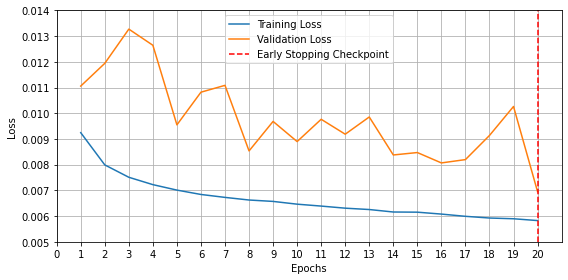

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_08)+1), loss_train_08, label = 'Training Loss')
plt.plot(range(1,len(loss_val_08)+1), loss_val_08, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_08.index(min(loss_val_08)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.005, 0.014) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_08)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 20

In [ ]:
## Check
print("Accuracy at epoch 20:", accuracy_val_08[loss_val_08.index(min(loss_val_08))])

Accuracy at epoch 20: 51.2


### P = 0.9

In [ ]:
norm_layer = "BN"
num_epochs = 20

## Init model (p = 0.9)
model_09 = ConvNet(input_size, hidden_size, num_classes, norm_layer = norm_layer, drop = 0.9).to(device)
model_09.apply(weights_init)

## Train Model
loss_train_09, loss_val_09, accuracy_val_09 =  train_model(model_09, early_stop = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [100/245], Loss: 2.1228
Epoch [1/20], Step [200/245], Loss: 1.9271


  5%|▌         | 1/20 [00:29<09:25, 29.74s/it]

Validation accuracy is: 10.2 %
Epoch [2/20], Step [100/245], Loss: 1.8989
Epoch [2/20], Step [200/245], Loss: 1.8861


 10%|█         | 2/20 [00:59<08:57, 29.84s/it]

Validation accuracy is: 11.4 %
Epoch [3/20], Step [100/245], Loss: 1.8602
Epoch [3/20], Step [200/245], Loss: 1.9736


 15%|█▌        | 3/20 [01:28<08:22, 29.58s/it]

Validation accuracy is: 10.5 %
Epoch [4/20], Step [100/245], Loss: 1.8140
Epoch [4/20], Step [200/245], Loss: 1.8981


 20%|██        | 4/20 [01:58<07:55, 29.69s/it]

Validation accuracy is: 10.7 %
Epoch [5/20], Step [100/245], Loss: 1.8263
Epoch [5/20], Step [200/245], Loss: 1.8130


 25%|██▌       | 5/20 [02:27<07:21, 29.46s/it]

Validation accuracy is: 10.3 %
Epoch [6/20], Step [100/245], Loss: 1.7407
Epoch [6/20], Step [200/245], Loss: 1.8608


 30%|███       | 6/20 [02:56<06:49, 29.28s/it]

Validation accuracy is: 10.3 %
Epoch [7/20], Step [100/245], Loss: 1.8615
Epoch [7/20], Step [200/245], Loss: 1.7289


 35%|███▌      | 7/20 [03:25<06:19, 29.21s/it]

Validation accuracy is: 10.8 %
Epoch [8/20], Step [100/245], Loss: 1.8514
Epoch [8/20], Step [200/245], Loss: 1.7956


 40%|████      | 8/20 [03:55<05:50, 29.20s/it]

Validation accuracy is: 10.5 %
Epoch [9/20], Step [100/245], Loss: 1.7330
Epoch [9/20], Step [200/245], Loss: 1.7236


 45%|████▌     | 9/20 [04:24<05:22, 29.28s/it]

Validation accuracy is: 10.1 %
Epoch [10/20], Step [100/245], Loss: 1.7866
Epoch [10/20], Step [200/245], Loss: 1.8316


 50%|█████     | 10/20 [04:53<04:52, 29.20s/it]

Validation accuracy is: 10.2 %
Epoch [11/20], Step [100/245], Loss: 1.7826
Epoch [11/20], Step [200/245], Loss: 1.6831


 55%|█████▌    | 11/20 [05:22<04:22, 29.18s/it]

Validation accuracy is: 10.2 %
Epoch [12/20], Step [100/245], Loss: 1.6618
Epoch [12/20], Step [200/245], Loss: 1.7321


 60%|██████    | 12/20 [05:51<03:53, 29.22s/it]

Validation accuracy is: 10.2 %
Epoch [13/20], Step [100/245], Loss: 1.7281
Epoch [13/20], Step [200/245], Loss: 1.7564


 65%|██████▌   | 13/20 [06:21<03:25, 29.30s/it]

Validation accuracy is: 10.2 %
Epoch [14/20], Step [100/245], Loss: 1.7661
Epoch [14/20], Step [200/245], Loss: 1.6437


 70%|███████   | 14/20 [06:51<02:56, 29.39s/it]

Validation accuracy is: 10.2 %
Epoch [15/20], Step [100/245], Loss: 1.6728
Epoch [15/20], Step [200/245], Loss: 1.7115


 75%|███████▌  | 15/20 [07:20<02:27, 29.48s/it]

Validation accuracy is: 10.2 %
Epoch [16/20], Step [100/245], Loss: 1.6721
Epoch [16/20], Step [200/245], Loss: 1.8643


 80%|████████  | 16/20 [07:50<01:57, 29.46s/it]

Validation accuracy is: 10.4 %
Epoch [17/20], Step [100/245], Loss: 1.6736
Epoch [17/20], Step [200/245], Loss: 1.6012


 85%|████████▌ | 17/20 [08:19<01:28, 29.44s/it]

Validation accuracy is: 10.2 %
Epoch [18/20], Step [100/245], Loss: 1.6590
Epoch [18/20], Step [200/245], Loss: 1.7252


 90%|█████████ | 18/20 [08:48<00:58, 29.42s/it]

Validation accuracy is: 10.3 %
Epoch [19/20], Step [100/245], Loss: 1.5951
Epoch [19/20], Step [200/245], Loss: 1.5983


 95%|█████████▌| 19/20 [09:18<00:29, 29.38s/it]

Validation accuracy is: 10.3 %
Epoch [20/20], Step [100/245], Loss: 1.6545
Epoch [20/20], Step [200/245], Loss: 1.7358


100%|██████████| 20/20 [09:47<00:00, 29.40s/it]

Validation accuracy is: 10.3 %


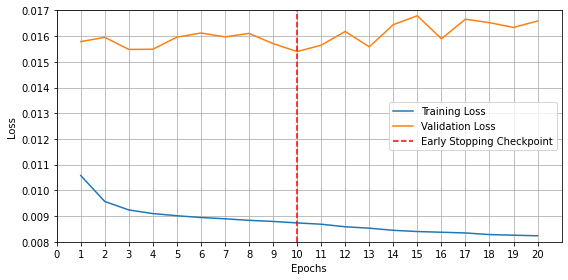

In [ ]:
## Plot validation and training losses

# visualize the loss as the network trained
fig = plt.figure(figsize = (8,4))
plt.plot(range(1,len(loss_train_09)+1), loss_train_09, label = 'Training Loss')
plt.plot(range(1,len(loss_val_09)+1), loss_val_09, label = 'Validation Loss')

# find position of lowest validation loss
minposs = loss_val_09.index(min(loss_val_09)) + 1 
plt.axvline(minposs, linestyle = '--', color = 'r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.008, 0.017) # consistent scale
plt.xticks(range(0, num_epochs+1))
plt.xlim(0, len(loss_train_09)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## Min Loss: epoch 10

In [ ]:
## Check
print("Accuracy at epoch 10:", accuracy_val_09[loss_val_09.index(min(loss_val_09))])

Accuracy at epoch 10: 10.2


### Comparison

In [ ]:
## Comparison

## creating the dataset
res = {"0.1" : accuracy_val_01[loss_val_01.index(min(loss_val_01))],
       "0.2" : accuracy_val_02[loss_val_02.index(min(loss_val_02))],
       "0.3" : accuracy_val_03[loss_val_03.index(min(loss_val_03))],
       "0.4" : accuracy_val_04[loss_val_04.index(min(loss_val_04))],
       "0.5" : accuracy_val_05[loss_val_05.index(min(loss_val_05))],
       "0.6" : accuracy_val_06[loss_val_06.index(min(loss_val_06))],
       "0.7" : accuracy_val_07[loss_val_07.index(min(loss_val_07))],
       "0.8" : accuracy_val_08[loss_val_08.index(min(loss_val_08))],
       "0.9" : accuracy_val_09[loss_val_09.index(min(loss_val_09))]}
probs = list(res.keys())
values = list(res.values())

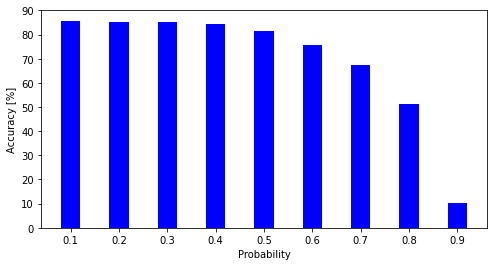

In [ ]:
## Plot
fig = plt.figure(figsize = (8, 4))
plt.bar(probs, values, color = "blue", width = 0.4)
plt.xlabel("Probability")
plt.ylabel("Accuracy [%]")
plt.ylim(0, 90)
plt.show()

We note that increasing the value of **p**, the value of accuracy deacreases and
this is due to the fact that the model is too simple and increasing p.

We can conclude that in this case the dropout is not so useful.